---
# LG Smart Mirror Image Extraction

In [1]:
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np
import statistics
import subprocess
import os, shutil
import pandas as pd
from glob import glob
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm
from time import sleep

class ImageExtractor:
    def __init__(self, rootPath, itemName):
        self.cap = None
        self.errorArr = []
        self.rawDirPath = ""
        self.distArrFilitered_flat=[]  # 센터 거리값 규칙 통과한 것들 flat하게 저장
        self.imageWidth = 224 # 추출할 이미지 너비
        self.imageHeight = 224 # 추출할 이미지 높이 
        self.itemName = itemName
        self.rootPath = rootPath
        self.videoPath = os.path.join(self.rootPath, "videos", self.itemName+'.mp4')
        self.videoResizedPath = os.path.join(self.rootPath, "videos_resized", self.itemName+'.mp4')
        self.videoResizedDirPath = os.path.join(self.rootPath, "videos_resized")
        self.imgDirPath = os.path.join(self.rootPath, "images", self.itemName)
        self.imgExtDirPath = os.path.join(self.rootPath, "images_ext", self.itemName)
        
        assert bool(self.itemName), "itemName should not be null value."
        # self.get_image_info()
        self.get_video_info(self.videoPath)

    # get video length for metadata crashed file
    def get_video_length(self):
        cnt=0
        self.cap = cv2.VideoCapture(self.videoResizedPath)
        while(True):
            ret, frame = self.cap.read()
            if ret:
                cnt+=1
            else: break
        self.videoLength = cnt
        self.cap.release()
        return cnt

    # get meta infomations 
    def get_image_info(self):
        file_list = os.listdir(self.imgDirPath)
        self.videoLength = file_list
        self.videoHeight, self.videoWidth, self.fps = cv2.imread(os.path.join(self.imgDirPath, file_list[0])).shape
        return

    # 비디오 정보 가져오기(비디오용)
    def get_video_info(self, infilename):
        self.cap = cv2.VideoCapture(infilename)
        if not self.cap.isOpened():
            print("could not open :", infilename)
            exit(0)

        self.videoLength = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.videoWidth = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.videoHeight = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.cap.release()
        return

    # 비디오 리사이징(비디오용)
    def resizeVideo(self):
        # get original video meta infomation
        videoName = self.itemName+'.mp4'
        self.get_video_info(self.videoPath)

        # 리사이징된 비디오 파일 저장 패스
        if not os.path.isdir(self.videoResizedDirPath): os.makedirs(self.videoResizedDirPath)

        # make resized video
        # 'ffmpeg -i "video/190703/AGE20_S-essence cover tx.mp4" -vf scale=-1:960 video/resized/out.mp4'
        if os.path.isfile(self.videoResizedPath):
            print('[Notice]:', self.videoResizedPath, 'aleady exist. remove it!')     
            os.remove(self.videoResizedPath)       

        # 비디오 스케일 종횡비 결정
        if self.videoWidth>1000 or self.videoHeight>1000:
            w = int(self.videoWidth/2)
            h = int(self.videoHeight/2)
            # scale = "scale=-1:%d"%(h)
            scale = "scale=iw/2:-1"
            # scale = "scale=%d:%d"%(w,h) # 이거 하면 원본 oritation 정보 잃어버림
            command = ['ffmpeg', '-i', self.videoPath, '-vf', scale, self.videoResizedPath]
        else: # just copy and rename video file
            command = ['cmd', '\/c', 'copy', self.videoPath, self.videoResizedPath]

        print('[Command]: \n', command)
        # 커맨드 실행    
        try:
            cmd_res = subprocess.check_output(command)
            print(cmd_res)
            print('[self.videoResizedPath]:', self.videoResizedPath)
            self.get_video_info(self.videoResizedPath)
        except:
            print('***[Error occured]: ffmpeg', self.videoResizedPath)

        return

    # 카메라 중심에서의 거리계산 
    def calcDist(self, d):
        cx = self.videoWidth/2
        cy = self.videoHeight/2
        x=d[0]; y=d[1]; width=d[2]; height=d[3]
        x_c = x+width/2
        y_c = y+height/2
        dist = math.sqrt((cx-x_c)**2 + (cy-y_c)**2)
        return (d, dist)

    # 면적비를 이용해 유효한 사각영역 계산
    def mergeRect(self, rectArr, PreFrameArea, PreRect, ratio=.8):
        # dist threshold 기준 계산
        distArr = np.array([e[-1] for e in rectArr])
        distDiffArr = distArr[1:] - distArr[:-1]
        if len(rectArr)>2: threshold = statistics.median(distDiffArr)*10 # 20은 사후 검토값이므로 바뀔 수 있음
        else: threshold = math.inf

        finRec = (int(self.videoWidth/2), int(self.videoHeight/2) ,0,0)
        netArea = self.videoHeight*self.videoWidth
        prewidth = PreRect[2]-PreRect[0]
        preheight = PreRect[3]-PreRect[1]
        precalcArea = math.inf
        predist=math.inf
        self.distArrFilitered_flat.append(0)
        for rect in rectArr:
            rectOnly, dist = rect
            x = min(finRec[0], rectOnly[0])
            y = min(finRec[1], rectOnly[1])
            x2= max(finRec[2], rectOnly[0]+rectOnly[2])
            y2= max(finRec[3], rectOnly[1]+rectOnly[3])
            width = x2-x
            height = y2-y

            # 사각 영역 합치는 주요 규칙
            if self.calcArea([x, y, x2, y2])> netArea*ratio: break # 전체면적 비율 제한 (ratio 이상시 멈춤)
            if self.calcArea([x, y, x2, y2])> netArea*0.2: # 초반에 전체면적대비 20%까지는 아래 조건들 무시
                # if dist>predist*1.8: break
                if dist-predist>threshold: break # 센터 거리값으로 제한 - 우하단에 멀리있는거 머지하는것 방지. 너무 초기에는 작동안해야 함.
                if self.calcArea((x,y,x2,y2)) > precalcArea*1.8: break # 합치다가 갑자기 늘어나는 면적 비율 제한 (1.8배 이상시 멈춤)

            if self.calcArea([x, y, x2, y2])> PreFrameArea*1.8: break # 이전 프레임에서 그린 rect보다 갑자기 늘어나는 면적 비율 제한
            if width/prewidth>1.8 or height/preheight>1.8: break # 이전 프레임에서 그린 rect 보다 width, height 가 1.8배 늘어나는 것 제한
            self.distArrFilitered_flat.append(dist)
            finRec = (x,y,x2,y2)
            precalcArea = self.calcArea(finRec)
            predist = dist
            # print(self.calcArea(finRec), netArea*ratio)
        return finRec

    # 카메라 중점부터 사각영역 합치기
    def mergeByDist(self, data, PreFrameArea, PreRect, ratio=.8):    
        rects = [self.calcDist(d) for d in data]
        rects = sorted(rects, key=lambda x: x[-1]) # 중점 거리순으로 소팅
        # rects = np.array(rects)
        # pprint.pprint(rects)
        return self.mergeRect(rects, PreFrameArea, PreRect, ratio)

    # 사각형 면적 계산
    def calcArea(self, rect):
        return (rect[2]-rect[0])*(rect[3]-rect[1])

    # 검출영역 저장
    def saveImage(self, frame, detectedRect_orig, videoname, idx):
        width, height = self.imageWidth, self.imageHeight
        ratio = height/width
        detectedRect= list(detectedRect_orig)

        detectedRect_width = detectedRect[2]-detectedRect[0]
        detectedRect_height = detectedRect[3]-detectedRect[1]
        ratio_detected = detectedRect_height/detectedRect_width

        # reshape image
        # ratio 맞춰주기
        if(ratio>ratio_detected): # 가로가 긴 경우
            upMargin = math.ceil((detectedRect_width - detectedRect_height)/2)
            downMargin = math.floor((detectedRect_width - detectedRect_height)/2)
            detectedRect[1] = detectedRect[1] - upMargin
            detectedRect[3] = detectedRect[3] + downMargin
        else: # 세로가 긴경우
            leftMargin = math.ceil((detectedRect_height - detectedRect_width)/2)
            rightMargin = math.floor((detectedRect_height - detectedRect_width)/2)
            detectedRect[0] = detectedRect[0] - leftMargin
            detectedRect[2] = detectedRect[2] + rightMargin

        # 검출영역의 width가 프레임 밖으로 넘어가는 경우 보정
        if(detectedRect[0]<0):
            detectedRect[2] = detectedRect[2] - detectedRect[0]
            detectedRect[0] = 0
        elif(detectedRect[2]>self.videoWidth):
            detectedRect[0] = detectedRect[0] - (self.videoWidth-detectedRect[2])
            detectedRect[2] = self.videoWidth
        # 검출영역의 height가 프레임 밖으로 넘어가는 경우 보정    
        if(detectedRect[1]<0):
            detectedRect[3] = detectedRect[3] - detectedRect[1]
            detectedRect[1] = 0
        elif(detectedRect[3]>self.videoHeight):
            detectedRect[1] = detectedRect[1] - (self.videoHeight-detectedRect[3])
            detectedRect[3] = self.videoHeight    

        # 마지막으로 화면 넘어간 영역 정리
        if(detectedRect[0]<0): detectedRect[0] = 0
        if(detectedRect[2]>self.videoWidth): detectedRect[2] = self.videoWidth
        if(detectedRect[1]<0): detectedRect[1] = 0
        if(detectedRect[3]>self.videoHeight): detectedRect[3] = self.videoHeight            

        # 임시 에러 로그 확인용 (정사각형 ratio나오지 않는것 확인)
        # detectedRect_width = detectedRect[2]-detectedRect[0]
        # detectedRect_height = detectedRect[3]-detectedRect[1]
        # ratio_detected = detectedRect_height/detectedRect_width
        # if(ratio_detected != 1): print('*****ratio limit********', detectedRect, ratio_detected)

        imgPath = os.path.join(self.imgExtDirPath, str(videoname)+'_'+str(idx)+'.jpg')

        try:
            # trim image
            img_trim = frame[detectedRect[1]:detectedRect[3], detectedRect[0]:detectedRect[2]] # y1, y2, x1, x2   
            # image resizing
            img_modi = cv2.resize(img_trim, (width, height), interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(imgPath, img_modi) # 이미지 저장
        except:
            print('[Save Img Error:]', detectedRect_orig, detectedRect)

        return detectedRect

    def preprocessVideo(self, SHOW_IMAGE = True):
        # 옵션 설명 http://layer0.authentise.com/segment-background-using-computer-vision.html
        fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=100, detectShadows=False)

        allData = [] # merged rect 저장하는 배열
        mergedAreas = [] # merged rect 넓이만저장하는 배열
        RectArea = self.videoHeight*self.videoWidth # initiation for put preframeArea to mergeRect 
        mergedRect= (0,0,self.videoWidth,self.videoHeight)

        self.get_video_length()
        self.cap = cv2.VideoCapture(self.videoResizedPath)
        for i in tqdm(range(self.videoLength)):
            ret, frame = self.cap.read()
            if ret:
        # for fn in tqdm(glob(self.imgDirPath+'\\*.jpg')):
        #     frame = cv2.imread(fn)
        #     if(frame.shape[0]>0):

                fgmask = fgbg.apply(frame)     
                edge = cv2.Canny(fgmask, 0,200) # bgmask에 canny edge detection 적용
                nlabels, _labels, stats, centroids = cv2.connectedComponentsWithStats(edge)

                data = []
                for index, centroid in enumerate(centroids):
                    if stats[index][0] == 0 and stats[index][1] == 0:  #x,y
                        continue
                    if np.any(np.isnan(centroid)):
                        continue

                    x, y, width, height, area = stats[index]
                    centerX, centerY = int(centroid[0]), int(centroid[1])

                    if area > 20: #  컨벡스헐 크기
                        # 유효한 값만 저장
                        data.append(stats[index])

                        if(SHOW_IMAGE):
                            cv2.circle(frame, (centerX, centerY), 1, (0, 255, 0), 2)
                            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0))

                data = np.array(data)

                # 머지된 사각형 그리기
                mergedRect = self.mergeByDist(data, RectArea, mergedRect, ratio=.7)
                cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
                RectArea = self.calcArea(mergedRect)
                mergedAreas.append(RectArea)

                if(SHOW_IMAGE):
                    cv2.putText(frame, str(len(allData))+' RectArea '+str(RectArea), \
                                (30,self.videoHeight-30),cv2.FONT_HERSHEY_SIMPLEX, 1, (100,0,225), 3) # 프레임 id, 선별영역 넓이
                    cv2.circle(frame, (int(self.videoWidth/2), int(self.videoHeight/2)), 1, (0,0,0), 6) # 중심점 렌더
                    cv2.putText(frame, str(len(data)), (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3) # 엣지 컨벡스헐 개수
                    # 영역 각각 그리기
                    cv2.imshow('bgsub', fgmask)
                    cv2.imshow('edge', edge)
                    cv2.imshow('frame',frame)


                k = cv2.waitKey(1) & 0xff 
                if k == 27: # esc
                    break

                allData.append(mergedRect)  
            else: break

        cv2.destroyAllWindows()    
        self.allData = allData
        self.mergedAreas = mergedAreas
        return

    def getStatistics(self, SHOW_PLOT=True):
        # -------------- 모든 유효한 dist 확인 -------------------
        if(SHOW_PLOT):
            print("distArrFilitered_flat_median:", statistics.median(self.distArrFilitered_flat))
            data_dist = np.array(self.distArrFilitered_flat[:1000])
            plt.figure(figsize=(18,9))
            plt.plot(data_dist[:], label="distArrFilitered_flat")
            plt.plot(data_dist[1:]-data_dist[:-1], label="distArrFilitered_flat diff")
            plt.legend(loc='upper right')
            plt.title("Dist per frame")
            plt.show()

        # --------------- 병합된 면적에서 + - 1.5 sigma 확인 (mean값 사용) -----------------------
        mergedAreas = np.array(self.mergedAreas)
        diff = abs(mergedAreas[1:] - mergedAreas[:-1])
        diff_median = statistics.median(diff)
        diff_mean = np.sum(diff)/len(diff)

        # 통계량 계산
        var= sum([math.pow(i, 2) for i in mergedAreas]) / len(mergedAreas) - math.pow(mergedAreas.mean(), 2)
        std = math.sqrt(var)
        upperBound = mergedAreas.mean()+ std*1.5
        lowerBound = mergedAreas.mean()- std

        # print("diff_median:", diff_median, ", diff_mean:", diff_mean)

        if(SHOW_PLOT):
            plt.figure(figsize=(18,9))
            plt.plot(mergedAreas, label="mergedArea")
            plt.plot(abs(mergedAreas[1:] - mergedAreas[:-1]), label="mergedArea diff")
            plt.axhline(upperBound, color='r')
            plt.axhline(lowerBound, color='r')
            plt.legend(loc='upper right')
            plt.title("Merged Rect Area")
            plt.show()

        # ------------------ 면적비 차분 통계량 (median값 사용) -------------------------
        mergedAreas = np.array(self.mergedAreas)
        diff_ratio = abs(mergedAreas[1:] - mergedAreas[:-1])/mergedAreas[1:]
        diff_ratio_median = statistics.median(diff_ratio)
        diff_ratio_mean = np.sum(diff_ratio)/len(diff_ratio)

        if(SHOW_PLOT):    
            print('diff_ratio_median:', diff_ratio_median, ', diff_ratio_mean:', diff_ratio_mean)
            plt.figure(figsize=(18,9))
            plt.plot(diff_ratio, label="abs area ratio")
            plt.axhline(diff_ratio_median*7, color='r')
            plt.axhline(diff_ratio_mean, color='g')
            plt.legend(loc='upper right')
            plt.title("Absolute area ratio")
            plt.show()

        # ------------------- 24프레임 단위로 윈도윙 보정 -----------------------
        meanArea24Frame=[]
        referenceAllData=[(0, i) for i in self.allData]

        if(len(mergedAreas)>=24):
            #0-23 frame mean
            sum_ = 0
            for i in range(0, 24):
                sum_ += mergedAreas[i]
                meanArea24Frame.append(sum_/(i+1))

            #24-end 24 frame mean
            for i in range(24,len(mergedAreas)):
                sum_ = 0
                for j in range(24):
                    sum_ += mergedAreas[i-j]
                meanArea24Frame.append(sum_/24)

            #check Area is much more bigger than mean (in this case twice)
            for i in range(len(mergedAreas)):
                # print(i, meanArea24Frame[i], mergedAreas[i])
                if(mergedAreas[i]/meanArea24Frame[i] > 2):
                    # print(i, 'data :',mergedAreas[i], 'mean :',meanArea24Frame[i])
                    j = 0
                    while(1):
                        j += 1
                        if(mergedAreas[i-j]/meanArea24Frame[i-j] < 2):
                            referenceAllData[i] = (1,self.allData[i-j])
                            # print(i, i-j, self.allData[i], self.allData[i-j],referenceAllData[i])
                            break

        self.statistics = {
          "upperBound":upperBound, 
          "lowerBound":lowerBound, 
          "diff_ratio_mean":diff_ratio_mean, 
          "diff_ratio_median":diff_ratio_median,
          "referenceAllData":referenceAllData
        }
        return

    def extractImages(self, SHOW_IMAGE = True):
        print('[Extract Images]:', self.itemName)
        idx = 0
        shrink_ratio = 0.5 #  abnormal 관측시 5%씩 증감
        shrink_ratio_s = 0.5
        margin = 0.02 # 검출영역 마진
        cnt = 0 # 저장용 프레임 체크용
        save_cnt = 0 # 저장용 파일명 인덱스용
        preRect = []
        detectedRect= [0,0,0,0]

        # 추출될 이미지 저장 폴더 비우기... 비동기 버그 때문에 sleep넣음 
        if os.path.isdir(self.imgExtDirPath): shutil.rmtree(self.imgExtDirPath)
        sleep(0.1)
        os.makedirs(self.imgExtDirPath)

        self.cap = cv2.VideoCapture(self.videoResizedPath)
        for i in tqdm(range(self.videoLength)):
            ret, frame = self.cap.read()
            if ret:
        # for fn in tqdm(glob(self.imgDirPath+'\\*.jpg')):
        #     frame = cv2.imread(fn)
        #     if(frame.shape[0]>0):

                mergedRect = self.allData[idx]
                frame_for_save = frame.copy()
                if bool(preRect):
                    # 갑작스럽게 영역의 수축/팽창이 일어나는 경우
                    diff_area = self.calcArea(mergedRect)-self.calcArea(preRect)
                    # 이전 영역대비 수축/팽창 비율 에러 윈도윙 보정 적용, calcArea(preRect)는 0이 아니어야함
                    if self.statistics['referenceAllData'][idx][0] or (self.calcArea(preRect)!=0 and self.statistics['diff_ratio_median'] < abs(diff_area)/self.calcArea(preRect)):                        
                        if(self.statistics['referenceAllData'][idx][0]):
                            preRect = self.statistics['referenceAllData'][idx][1]

                        if diff_area>0: # 갑자기 커지는 경우
                            cv2.putText(frame, str(idx)+' abnormal dilation', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)
                            # 이전 프레임보다 줄어들면 안됨... 어차피 팽창하는 경우라
                            x = max(preRect[0]*(1-shrink_ratio)+mergedRect[0]*shrink_ratio, 0)
                            y = max(preRect[1]*(1-shrink_ratio)+mergedRect[1]*shrink_ratio, 0)
                            x2 = min(preRect[2]*(1-shrink_ratio)+mergedRect[2]*shrink_ratio, self.videoWidth)
                            y2 = min(preRect[3]*(1-shrink_ratio)+mergedRect[3]*shrink_ratio, self.videoHeight) 
                            if (x2-x)>(mergedRect[2]-mergedRect[0]):
                                x = mergedRect[0]
                                x2 = mergedRect[2]
                            if (y2-y)>(mergedRect[3]-mergedRect[1]):
                                y = mergedRect[1]
                                y2 = mergedRect[3]

                        else: # 갑자기 작아지는 경우
                            cv2.putText(frame, str(idx)+' abnormal shrinkage', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                            x = preRect[0]*(1-shrink_ratio_s)+mergedRect[0]*shrink_ratio_s
                            y = preRect[1]*(1-shrink_ratio_s)+mergedRect[1]*shrink_ratio_s
                            x2 = preRect[2]*(1-shrink_ratio_s)+mergedRect[2]*shrink_ratio_s
                            y2 = preRect[3]*(1-shrink_ratio_s)+mergedRect[3]*shrink_ratio_s

                        mergedRect = (int(x), int(y), int(x2), int(y2))

                    # 마진 넣기
                    width = preRect[2]-preRect[0]
                    height = preRect[3]-preRect[1]
                    detectedRect = (int(max(mergedRect[0]-width*margin/2, 0)),
                                    int(max(mergedRect[1]-height*margin/2, 0)),
                                    int(min(mergedRect[2]+width*margin/2, self.videoWidth)),
                                    int(min(mergedRect[3]+height*margin/2, self.videoHeight)) )
                    if(self.calcArea(detectedRect) > self.statistics['upperBound']): cv2.putText(frame, 'UPPER BOUND', (detectedRect[0], detectedRect[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                    elif(self.calcArea(detectedRect) < self.statistics['lowerBound']): cv2.putText(frame, 'LOWER BOUND', (detectedRect[0], detectedRect[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                    else: 
                        cnt+=1
                        # n번째마다 저장
                        if(cnt% 5 ==0): 
                            save_cnt += 1
                            savedRect = self.saveImage(frame_for_save, detectedRect, self.itemName, save_cnt)
                            cv2.putText(frame, 'Save image', (40, self.videoHeight), cv2.FONT_HERSHEY_SIMPLEX, 1, (225,0,0), 3)        
                            cv2.rectangle(frame, (savedRect[0], savedRect[1]), (savedRect[2], savedRect[3]), (255, 0, 0), 2)        
        #                     cv2.imshow('frame',frame)
        #                     sleep(0.5)                          

                if idx>0: # 첫 프레임 무시
                    preRect = mergedRect          

                if SHOW_IMAGE:
                    cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
                    cv2.rectangle(frame, (detectedRect[0], detectedRect[1]), (detectedRect[2], detectedRect[3]), (0, 255, 255), 2)
                    cv2.imshow('frame',frame)
        #         sleep(0.5)
        #         cv2.imwrite('./img/'+str(self.itemName)+'_'+str(idx)+'.jpg', frame[detectedRect[1]:detectedRect[3], detectedRect[0]:detectedRect[2]]) # 이미지 저장

                k = cv2.waitKey(1) & 0xff 
                if k == 27: # esc
                    break

            else: break
            idx += 1    

        if self.cap: self.cap.release()
        cv2.destroyAllWindows()      
        return  

In [21]:
%%time
itemName = "LG-praL2"
rootPath = ".\\server\\oracle_proj"
extractor = ImageExtractor(rootPath, itemName)

Wall time: 14 ms


In [22]:
extractor.resizeVideo()

[Notice]: .\server\oracle_proj\videos_resized\LG-praL2.mp4 aleady exist. remove it!
[Command]: 
 ['ffmpeg', '-i', '.\\server\\oracle_proj\\videos\\LG-praL2.mp4', '-vf', 'scale=iw/2:-1', '.\\server\\oracle_proj\\videos_resized\\LG-praL2.mp4']
b''
[self.videoResizedPath]: .\server\oracle_proj\videos_resized\LG-praL2.mp4


In [6]:
# 비디오 전처리
extractor.preprocessVideo(SHOW_IMAGE = True)
# 통계량 추출
extractor.getStatistics(SHOW_PLOT=False)
# 결과 이미지 영역 크롭
extractor.extractImages(SHOW_IMAGE=True)

100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [00:15<00:00, 34.08it/s]


[Extract Images]: LG-praL2


100%|███████████████████████████████████████████████████████████████████████████████| 515/515 [00:02<00:00, 174.72it/s]


In [32]:
extractor.cap.release()
cv2.destroyAllWindows()      

---
# CLASS

In [582]:
# model.embedded_features.shape
%timeit output.sort()

382 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [583]:
%timeit output.argmax(dim=0)

506 µs ± 974 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [592]:
model.dists_sorted.indices.shape
model.predicts

tensor([[10,  8, 17],
        [10, 17,  8],
        [ 8, 10, 17],
        [10,  8, 17],
        [10, 17,  8],
        [10, 17,  8],
        [10, 17,  8],
        [10, 17,  8],
        [10,  8, 17],
        [ 4, 19,  6]], device='cuda:0')

In [581]:
# input1 = torch.randn(50000, 1280).to('cuda')
# input2 = torch.randn(1280).to('cuda')
%time output = (input1-input2).norm(dim=1)
%time output.sort()
%time output.argmax(dim=0)

"""
roi하나당 1ms정도 나오네...
100개 쓰면 100ms... 느려 너무
"""

Wall time: 0 ns
Wall time: 1 ms
Wall time: 0 ns


'\nroi하나당 1ms정도 나오네...\n100개 쓰면 100ms... 느려 너무\n'

In [554]:
# %time input1 = torch.randn(50000, 1280)
# %time input2 = torch.randn(1280).unsqueeze(0)
input3 = input2.unsqueeze(0)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
%time output = cos(input1, input3)
output.shape

Wall time: 999 µs


torch.Size([50000])

In [63]:
input1 = torch.randn(1, 3, 224, 224).data.to('cuda')
input2 = torch.randn(120, 3, 224, 224).data.to('cuda')

%time outputs = model(input1)
# %time outputs = model(input2)
# %time model.inference_tensor2(input1, metric='cos')
# %time model.inference_tensor2(input2, metric='cos')
# outputs
outputs.shape
# print(outputs.data[0][0])

Wall time: 21 ms


torch.Size([1, 512])

In [67]:
boxes = torch.tensor([[10,20,100,200.0]]).cuda()
crops = torchvision.ops.roi_align(input1, [boxes], [224,224])
crops.shape

torch.Size([1, 3, 224, 224])

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import cv2
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from torch.distributions.multivariate_normal import MultivariateNormal
from tqdm import tqdm
import mymodels
from mymodels.BN_Inception import BN_Inception

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class OracleModel(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(OracleModel, self).__init__()
#         ****torch pretrained net****
#         net = models.shufflenetv2.shufflenet_v2_x1_0(pretrained=True) # 1024
        net = models.resnet50(pretrained=True)
#         net = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
#         net = models.mobilenet_v2(pretrained=True)
#         net = models.densenet201(pretrained=True)
#         self.backbone = net
        modules = list(net.children())[:-1]      # delete the last fc layer.
        avg_pool = torch.nn.AvgPool2d(7, stride=1)
        flatten = Flatten()
#         self.backbone = torch.nn.Sequential(*modules, avg_pool, flatten) #1280    
        self.backbone = torch.nn.Sequential(*modules, flatten) # 2048

# #         ****mobilenet****
#         self.BACKBONE_PATH = 'torch_models/mobile_ft.pt'
#         mobilenet = torch.load(self.BACKBONE_PATH)
#         modules = list(mobilenet.children())[:-1]
#         avg_pool = torch.nn.AvgPool2d(7, stride=1)
#         flatten = Flatten()
#         self.backbone = torch.nn.Sequential(*modules, avg_pool, flatten) #1280
        
# #         ****mobilnet distance matric learning****   
#         self.BACKBONE_PATH = 'mymodels/model_000400.pth'
#         self.backbone = torch.load(self.BACKBONE_PATH) #1280    

#         self.backbone = mymodels.create('Resnet50', dim=512, pretrained=True,
#                                         model_path='mymodels/ckp_ep210.pth.tar') #[227,227]->512

#         self.backbone = BN_Inception(dim=512, pretrained=True, 
#                                      model_path='mymodels/bn_inception-52deb4733.pth')
    
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.topk = 3
        self.threshold = 0.75
        self.feature_len = 512
#         self.feature_len = 2048

        self.sort_order_descending = False
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.roi_upsample = nn.UpsamplingBilinear2d([224,224])
        self.roi_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

    def forward(self, images):
        """Extract feature vectors from input images."""
        return self.backbone(images)[:,:self.feature_len]

    def makeAllReference_online(self, referenceImgDirPath):
        """
        임베딩 디비 생성... flask 서버용 
        utils.makeAllReferenceCSV 에서 csv 저장만 안함
        """
        reference_dataset = torchvision.datasets.ImageFolder(
            root=referenceImgDirPath,
            transform=transforms.Compose([
                transforms.Resize([224,224]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        )
        reference_loader = torch.utils.data.DataLoader(
            reference_dataset,
            batch_size=32,
            num_workers=0,
            shuffle=False
        )

        # get all data and input to model
        _temp = []
        for data, target in tqdm(reference_loader):
            outputs = self.forward(data.to(self.device)).data # .data 안하면 메모리 오버플로남...
            _temp.append(outputs)

        represented = torch.cat(_temp, dim=0)
        # raw data label 별 평균 구해두기
        df_ref = pd.DataFrame(represented.cpu().numpy())
        df_ref['label'] = [reference_dataset.classes[i] for i in reference_dataset.targets]
        reference_means = df_ref.groupby('label').mean()
        dir_list = reference_dataset.classes

        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(dir_list, df_ref, reference_means)
        return dir_list, df_ref, reference_means
        
    # 임베딩 디비 생성
    def setReferenceDataset(self, sample_dir_list, df_ref_featere_sampled, reference_means_sampled):
        self.reference_classes = sample_dir_list
        self.reference_targets = list(df_ref_featere_sampled.iloc[:,-1])
        self.embedded_features_cpu = torch.tensor(df_ref_featere_sampled.iloc[:,:-1].as_matrix()).float().data # float64->float32(torch default), cpu
        self.embedded_features = self.embedded_features_cpu.to(self.device) # gpu
        self.embedded_means_numpy = reference_means_sampled.as_matrix()
        self.embedded_means = torch.tensor(self.embedded_means_numpy).float().data.to(self.device) # float64->float32(torch default), gpu

        self.c2i = {c:i for i,c in enumerate(self.reference_classes)}
        self.embedded_labels = np.array([self.c2i[c] for c in self.reference_targets])
        
        # make datafames for plot
        # ***필요없음 어차피 pca 해야함
        self.df_ = pd.DataFrame(np.array(self.embedded_features_cpu))
        self.df_['name'] = self.reference_targets
        self.centers_ = pd.DataFrame(self.embedded_means_numpy)
        self.centers_['name'] = self.reference_classes

    def fit_pca(self, n_components=4):
        # pca model fit
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components) # 2048 차원 다쓰면 나중에 샘플링에서 계산 오류남, sample 개수보다 많으면 촐레스키 분해 에러나는듯
        self.transformed = self.pca.fit_transform(self.embedded_features_cpu)

        # show PCA features 
        self.df = pd.DataFrame(self.transformed)
        self.df['name'] = self.reference_targets
        self.centers = pd.DataFrame(self.pca.transform(self.embedded_means_numpy))
        self.centers['name'] = self.reference_classes

    def inference_tensor2(self, inputs, metric='l2'):
        """
        @params metric: [l2, mahalanobis, prob]
        """
        # set metric function
        if metric == 'l2':
            self.metric_fn = self.calc_l2
            self.sort_order_descending = False
        elif metric == 'cos':
            self.metric_fn = self.calc_cos  
            self.sort_order_descending = True  

        # inputs shape: Batch*C*H*W
        # input to backbone model
        self.inputs = inputs
        self.outputs = self.forward(self.inputs).data # n_roi X features

        # inference
        if metric == 'l2':
            _diff = torch.stack([o-self.embedded_features for o in self.outputs]) # n_roi X classes X features
            self.dists = _diff.norm(dim=2, keepdim=True).squeeze()
        elif metric == 'cos':
            dists = [self.cos(self.embedded_features, o.unsqueeze(0)) for o in self.outputs]
            self.dists = torch.stack(dists)

        self.dists_sorted = self.dists.sort(dim=1, descending=self.sort_order_descending)
        self.predicts = torch.tensor(np.array([self.embedded_labels[idxs] for idxs in self.dists_sorted.indices.cpu()])).long()[:,:self.topk]
        self.predicts_dist = self.dists_sorted.values[:,:self.topk]
        return self.predicts.data, self.predicts_dist.data

    def inference_tensor(self, inputs, metric='l2'):
        """
        @params metric: [l2, mahalanobis, prob]
        """
        # set metric function
        if metric == 'l2':
            self.metric_fn = self.calc_l2
            self.sort_order_descending = False
        elif metric == 'cos':
            self.metric_fn = self.calc_cos  
            self.sort_order_descending = True  

        # inputs shape: Batch*C*H*W
        # input to backbone model
        self.inputs = inputs
        self.outputs = self.forward(self.inputs).data # n_roi X features

        # inference
        if metric == 'l2':
            _diff = torch.stack([o-self.embedded_means for o in self.outputs]) # n_roi X classes X features
            self.dists = _diff.norm(dim=2, keepdim=True).squeeze()
        elif metric == 'cos':
            dists = [self.cos(self.embedded_means, o.unsqueeze(0)) for o in self.outputs]
            self.dists = torch.stack(dists)

        self.dists_sorted = self.dists.sort(dim=1, descending=self.sort_order_descending)
        self.predicts = self.dists_sorted.indices[:,:self.topk]
        self.predicts_dist = self.dists_sorted.values[:,:self.topk]
        return self.predicts.data, self.predicts_dist.data

    # 각 레이블 별 평균과의 L2 거리 계산 (PCA 적용안함)
    def calc_l2(self, label):
        mu = self.embedded_means[label]
        xx = self.outputs

        # 20*1280 X 1280*20 --diag--> 20
        # num_roi*dim X dim*num_roi --diag--> num_roi
        xx_sub_mu = xx.sub(mu)
        l2_dist = xx_sub_mu.matmul(xx_sub_mu.t()).sqrt().diag()
        return l2_dist.cpu()

    # 각 레이블 별 평균과의 cosine simility 계산 (PCA 적용안함)
    def calc_cos(self, label):
        mu = self.embedded_means[label]
        xx = self.outputs

        # 20*1280 X 1280*20 --diag--> 20
        # num_roi*dim X dim*num_roi --diag--> num_roi
        mu = mu.unsqueeze(0)
        cos_dist = self.cos(xx, mu)
        return cos_dist.cpu()        

    def inference_file(self, imgPath):              
        # imgPath = ".\\server\\oracle_proj\\predict.jpg"
        frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
        return self.inference_tensor(frame)

    def show_img(self, imgPath):
        frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
        # opencv frme input // H*W*C(BGR)
        # 0-255 3 channel
        inputs = torch.Tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))/255 # 여기 Tensor 소문자로 바꾸면 안됨... 차이 알아보기
        plt.imshow(inputs)
        plt.show()
        
    def show_tensor(self, t):
        plt.imshow(t.numpy().transpose([1,2,0]))
        plt.show()
        
    def plot(self):
        self.fit_pca(n_components=4)
        _outputs = self.pca.transform(self.outputs.cpu())

        plt.figure(figsize=(18,9))
        plt.title("Vector space, pca_n: "+str(self.feature_len))
        ax = sns.scatterplot(x=0, y=1, hue='name', data=self.df, palette="Set1", legend="full")
        ax2 = sns.scatterplot(x=0, y=1, hue='name', data=self.centers, palette="Set1", s=150, legend=None, edgecolor='black')
        plt.scatter(_outputs[:,0], _outputs[:,1], marker='x', c='black')
        plt.show()

    # save plot image for web
    def save_plot(self):
        self.fit_pca(n_components=4)
        _outputs = self.pca.transform(self.outputs.cpu())

        plt.figure(figsize=(9,9))
        plt.title("Vector space, pca_n: "+str(self.feature_len))
        ax = sns.scatterplot(x=0, y=1, hue='name', data=self.df, palette="Set1", legend="full", s=30)
        ax2 = sns.scatterplot(x=0, y=1, hue='name', data=self.centers, palette="Set1", s=150, legend=None, edgecolor='black')
        plt.scatter(_outputs[:,0], _outputs[:,1], marker='x', c='black', s=120)
        plt.savefig(os.path.join('.\\static', 'plot.jpg'))

In [2]:
model = OracleModel()
model.to(model.device)
model.eval()

OracleModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, 

In [3]:
"""
차후 util로 리팩토링
"""
import PIL
# -------------- 전체 임베딩 피처 디비 생성 --------------
def makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath):
    """
    전체 임베딩 피처 dataframe 생성 후 csv로 저장
    """
    reference_dataset = torchvision.datasets.ImageFolder(
        root=referenceImgDirPath,
        transform=transforms.Compose([
#             transforms.Resize([224,224]),
            transforms.RandomHorizontalFlip(),
#             transforms.RandomRotation(45),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )
    reference_loader = torch.utils.data.DataLoader(
        reference_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )
    
    reference_dataset2 = torchvision.datasets.ImageFolder(
        root=referenceImgDirPath,
        transform=transforms.Compose([
#             transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(90),    
            transforms.CenterCrop(159),
            transforms.Resize([224,224]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )
    reference_loader2 = torch.utils.data.DataLoader(
        reference_dataset2,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )
    
#     # *********************cifar10***********************
#     reference_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, 
#             transform=transforms.Compose([
#             transforms.Resize([224,224]),
#             transforms.RandomHorizontalFlip(),
# #             transforms.RandomRotation(45),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ]))
#     reference_loader = torch.utils.data.DataLoader(reference_dataset, batch_size=8,
#                                               shuffle=False, num_workers=4)
#     # *********************cifar10***********************

    # get all data and input to model
    _temp = []
#     for data, target in tqdm(reference_loader2):
#         outputs = model(data.to(model.device)).data # .data 안하면 메모리 오버플로남...
#         _temp.append(outputs) 
    for data, target in tqdm(reference_loader):
        outputs = model(data.to(model.device)).data # .data 안하면 메모리 오버플로남...
        _temp.append(outputs)       

    represented = torch.cat(_temp, dim=0)
    # raw data label 별 평균 구해두기
    df_ref = pd.DataFrame(represented.cpu().numpy())
    df_ref['label'] = [reference_dataset.classes[i] for i in reference_dataset.targets*1]
    reference_means = df_ref.groupby('label').mean()

    # 자료 저장
    df_ref.to_csv('reference_features_cos.csv', encoding='utf8', index=False)
    reference_means.to_csv('reference_means_cos.csv', encoding='utf8', index=True)
    return


def set_sample_val_img(imgValPath, imgValTempPath, n_class_for_val, musthave_list=[]):
    """
    n개 클래스만 validation 샘플링 하는 함수
    @param imgValPath = '.\\img_real\\val'
    @param imgValTempPath = '.\\img_real\\_val_temp'
    @param n_class_for_val = 20
    @musthave_list = 반드시 포함할 리스트
    """
    all_dir_list = os.listdir(imgValPath)
    sample_dir_list = np.random.permutation(all_dir_list)[:n_class_for_val]
    for i in musthave_list:
        if i not in sample_dir_list: sample_dir_list = np.concatenate([sample_dir_list, [i]])

    # 추출될 이미지 저장 폴더 비우기... 비동기 버그 때문에 sleep넣음 
    if os.path.isdir(imgValTempPath): shutil.rmtree(imgValTempPath)
    sleep(0.1)
    os.makedirs(imgValTempPath)

    # copy sampled dir
    for class_name in tqdm(sample_dir_list):
        if not os.path.isdir(os.path.join(imgValTempPath, class_name)):
            os.mkdir(os.path.join(imgValTempPath, class_name))
        command = ['cmd', '\/c', 'copy',  os.path.join(imgValPath, class_name) , os.path.join(imgValTempPath, class_name)]    
        subprocess.check_output(command)
    sample_dir_list.sort() # 토치 데이터로더도 자동으로 이름순 소팅하므로 꼭 해야함
    return list(sample_dir_list)

def get_sample_reference(featuresPath, meanPath, showData=False):
    """
    n개 클래스 임베딩 & 레이블 & means 추출 
    """
    # load saved embedding features & means
    df_ref = pd.read_csv(featuresPath, encoding='utf8')
    reference_means = pd.read_csv(meanPath, encoding='utf8', index_col='label')
    
    if showData:
        display(df_ref)
        display(reference_means)

    df_ref_featere_sampled = None
    for c in sample_dir_list:
        _df = df_ref[df_ref['label'] == c]
        if df_ref_featere_sampled is None: df_ref_featere_sampled = _df
        else: df_ref_featere_sampled = df_ref_featere_sampled.append(_df)

    df_ref_featere_sampled = df_ref_featere_sampled.reset_index(drop=True)
    reference_means_sampled = reference_means.loc[sample_dir_list]
    return df_ref_featere_sampled, reference_means_sampled


In [151]:
"""
전체 피처 데이터 재생성
"""
# referenceImgDirPath = '.\\img4\\train'
referenceImgDirPath = '.\\img_real\\ref'

featuresPath = 'reference_features_cos.csv'
meanPath = 'reference_means_cos.csv'
makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath)

100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:21<00:00, 10.09it/s]


In [4]:
%%time
print('**********data folder re-generating***********')
imgValPath = '.\\img_real\\val'
# imgValPath = '.\\img4\\val'
imgValTempPath = '.\\img_real\\_val_temp'
n_class_for_val = 100
musthave_list = ['LG-praL']
# musthave_list = []


# -------------- n개 클래스만 validation 샘플링 세팅 및 폴더정리 ----------------
reference_dataset = torchvision.datasets.ImageFolder(
    root=imgValPath,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
sample_dir_list = reference_dataset.classes
# sample_dir_list = set_sample_val_img(imgValPath, imgValTempPath, n_class_for_val, musthave_list)

# # *********************cifar10***********************
# val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False,
#         transform=transforms.Compose([
#         transforms.Resize([224,224]),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]))
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
#                                          shuffle=True, num_workers=4)
# sample_dir_list = val_dataset.classes
# # *********************cifar10***********************

# -------------- 레퍼런스 데이터에서 n개 클래스 임베딩 & 레이블 & means 추출 -----------------
featuresPath = 'reference_features_cos.csv'
meanPath = 'reference_means_cos.csv'

df_ref_featere_sampled, reference_means_sampled = get_sample_reference(featuresPath, meanPath, showData=True)

# ---------------------------- 레퍼런스셋 로드 및 임베딩 세팅 ---------------------------------
model.setReferenceDataset(sample_dir_list, df_ref_featere_sampled, reference_means_sampled)

**********data folder re-generating***********


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,0.889461,1.400137,1.028329,0.359699,0.029861,0.221824,0.266100,1.048018,0.673278,0.376848,...,0.233339,0.501302,0.738522,0.039575,1.796203,0.776367,0.314317,0.146171,0.106512,AGE20_S-ESSENCE COVER FACT TX
1,1.504026,0.031375,0.749771,0.290218,0.445955,0.301378,0.293863,0.781486,0.264558,0.184890,...,0.339388,0.276355,1.192361,0.165395,0.282857,0.171867,0.847621,0.470855,0.524684,AGE20_S-ESSENCE COVER FACT TX
2,2.129459,0.620722,0.936661,0.458737,0.204746,0.091508,0.722183,0.769443,0.219759,0.278089,...,0.273157,0.350669,0.479599,0.265408,0.522251,0.085623,0.570674,1.169496,0.339586,AGE20_S-ESSENCE COVER FACT TX
3,0.847061,0.056681,0.080809,0.298973,0.887922,0.305651,0.001326,0.941080,0.212176,0.098744,...,0.723221,0.284325,1.088623,0.057658,0.966519,0.059482,1.423163,0.154649,0.664788,AGE20_S-ESSENCE COVER FACT TX
4,1.363035,0.088783,0.165561,0.384980,0.643363,0.472997,0.058967,0.572445,0.168475,0.154831,...,0.055164,0.131302,0.931047,0.037352,0.605435,0.004319,1.253530,0.357816,0.489046,AGE20_S-ESSENCE COVER FACT TX
5,0.737886,0.005247,0.440935,0.161203,0.335233,0.509597,0.605703,0.749886,0.125185,0.027075,...,0.332279,0.275307,0.756630,0.165926,0.268706,0.094076,0.304215,0.265050,0.473097,AGE20_S-ESSENCE COVER FACT TX
6,0.966084,0.459086,0.645653,0.060177,0.413481,0.407300,0.433513,0.244509,0.226471,0.089591,...,0.666346,0.491274,1.143583,0.123730,0.379804,0.326529,1.304363,0.296464,0.692195,AGE20_S-ESSENCE COVER FACT TX
7,1.182381,1.446700,0.217403,0.054266,0.344240,0.157744,0.050927,1.173181,0.233141,0.327247,...,0.097851,0.318771,0.727473,0.445850,0.153816,0.292142,1.448228,0.626110,0.563175,AGE20_S-ESSENCE COVER FACT TX
8,0.927444,0.263074,0.403288,0.131150,0.544433,0.294287,0.204268,0.653860,0.169953,0.421632,...,0.375870,0.193103,0.885059,0.127670,1.234503,0.121390,0.515099,0.186179,0.241879,AGE20_S-ESSENCE COVER FACT TX
9,0.610960,0.762470,0.328473,0.119980,0.513719,0.477637,0.363116,0.595388,0.318250,0.065723,...,0.503761,0.461024,0.534404,0.015746,0.286107,0.161752,0.963265,0.308686,0.454139,AGE20_S-ESSENCE COVER FACT TX


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
label,,,,,,,,,,,,,,,,,,,,,
AGE20_S-ESSENCE COVER FACT TX,0.887081,0.745793,0.573848,0.191461,0.341789,0.442605,0.246606,0.786173,0.294653,0.230775,...,0.939715,0.262702,0.390661,0.716760,0.183259,0.563572,0.224185,0.835425,0.333142,0.389093
AHC-AGELESS REAL EYE CREAM FOR FACE,0.765433,0.809667,1.099976,0.286078,0.734710,0.895647,0.313712,0.346367,0.450070,0.343541,...,0.394886,0.364112,0.208557,0.471021,0.551860,0.247814,0.415099,0.224843,0.474553,0.502096
ARITAUM-MONO EYES,0.628301,1.282789,0.424296,0.084628,0.617988,0.338015,0.342731,0.996790,0.252219,0.233990,...,1.133627,0.199471,0.320229,0.547458,0.140312,0.387902,0.440971,0.219251,0.227160,0.216262
BENEFIT-DANDELION,0.754632,1.326496,0.123342,0.090499,0.965803,0.365493,0.299054,0.603671,0.374266,0.050668,...,1.041845,0.164137,0.162862,0.706410,0.131741,0.291762,0.311908,0.114092,0.214326,0.352613
BEYOND-ANGEL AQUA DAILY BIG TONER,1.171508,0.545328,0.997204,0.336298,0.774130,0.669513,0.534764,0.552293,0.590949,0.167317,...,0.690832,0.175587,0.399398,0.786065,0.300205,0.260869,0.640259,0.187862,0.104886,0.459405
BEYOND-ANGEL AQUA MOIST CREAM,0.537258,0.577263,0.432369,0.205069,0.419617,0.309337,0.437310,1.004213,0.558829,0.243692,...,0.928606,0.183880,0.438229,1.059923,0.274046,0.330729,0.376074,0.250485,0.145269,0.227088
BEYOND-ECO DAILY DEFENCE AQUA SUN GEL,0.625205,1.302106,0.615718,0.163896,0.892154,1.544702,0.557288,0.424020,0.385859,0.158339,...,0.907528,0.146290,0.327324,0.445460,0.557523,0.273107,0.287971,0.171780,0.295625,0.208144
BEYOND-PHYTO AQUA CREAM,0.715180,0.905961,0.499943,0.115494,0.470397,0.392526,0.451653,0.665396,0.351421,0.135167,...,1.207133,0.143160,0.487226,0.760229,0.129587,0.512264,0.217857,0.249433,0.156144,0.108019
BIODERMA-SENSIBIO H2O MAKE,1.674743,1.165674,1.352994,0.352482,0.697298,1.395214,0.480063,0.264433,0.713432,0.486347,...,0.915643,0.081259,0.570339,0.357151,0.466104,0.265588,0.546937,0.593381,0.279834,0.615676


Wall time: 1.7 s


In [153]:
# ---------------------------- validation set 로드 ---------------------------------
val_dataset = torchvision.datasets.ImageFolder(
    root=imgValTempPath,
    transform=transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)

assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- validation set 정확도 측정 ---------------------------------
print('**********calculating***********')

target_all = []
preds_all = []
for data, target in tqdm(val_loader):
    preds, preds_dist = model.inference_tensor2(data.to(model.device), 'cos')
    target_all.append(target)
    preds_all.append(preds)
    

target_all=torch.cat(target_all, dim=0)
preds_all=torch.cat(preds_all, dim=0).data.cpu()
top1_acc = target_all.eq(preds_all[:,0]).float().mean()
top3_acc = np.mean([t in p for t,p in zip(target_all, preds_all)])

# groupby 통계량 보기
_res = []
for t,p in zip(target_all.numpy(), preds_all.numpy()):
    _res.append([val_dataset.classes[t],t,p,t==p[0], t in p])
_df_res = pd.DataFrame(_res, columns=['label', 'target', 'pred', 'top1', 'top3'])
res_agg_df = _df_res.groupby('label').mean()
res_agg_df['count'] = list(_df_res.groupby('target').count()['label'])

display(res_agg_df)
print("[top-1 acc]:", top1_acc, " [top-3 acc]:", top3_acc, " [all count]:",len(target_all))

**********calculating***********


100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:18<00:00,  7.39it/s]


,target,top1,top3,count
label,,,,
AGE20_S-ESSENCE COVER FACT TX,0,0.309524,0.547619,42
AHC-AGELESS REAL EYE CREAM FOR FACE,1,0.315789,0.421053,19
ARITAUM-MONO EYES,2,0.806452,0.870968,31
BENEFIT-DANDELION,3,0.415385,0.476923,65
BEYOND-ANGEL AQUA DAILY BIG TONER,4,0.500000,0.684211,38
BEYOND-ANGEL AQUA MOIST CREAM,5,0.756098,0.853659,41
BEYOND-ECO DAILY DEFENCE AQUA SUN GEL,6,0.105263,0.157895,38
BEYOND-PHYTO AQUA CREAM,7,0.600000,0.742857,35
BIODERMA-SENSIBIO H2O MAKE,8,0.816667,0.933333,60


[top-1 acc]: tensor(0.4932)  [top-3 acc]: 0.5866114561766735  [all count]: 4347


In [124]:
res_agg_df.loc['LG-praL']

target    61.000000
top1       0.897727
top3       0.920455
count     88.000000
Name: LG-praL, dtype: float64

In [44]:
%time preds, preds_dist = model.inference_tensor2(data.to(model.device), 'cos')
%time preds, preds_dist = model.inference_tensor(data.to(model.device), 'cos')

Wall time: 67 ms
Wall time: 41 ms


---
## +RPN

In [4]:
# ------------- non max suppression -------------
# https://wns349.github.io/2018/10/16/nms/

# Calc IOU
def calcIOU(box1, box2):
    area_box1 = box1[2]*box1[3]
    area_box2 = box2[2]*box2[3]
    x1_max = max(box1[0], box2[0])
    x2_min = min(box1[0]+box1[2], box2[0]+box2[2])
    y1_max = max(box1[1], box2[1])
    y2_min = min(box1[1]+box1[3], box2[1]+box2[3])
    
    area_intersection = max(0, x2_min-x1_max) * max(0, y2_min-y1_max)
    area_union = area_box1+area_box2-area_intersection +1e-9
    return area_intersection/area_union

def non_max_sup_one_class(bboxes, threshold=0.2, descending=False):
    """
    @params threshold - 
    @params ascending - 기본이 내림차순,
    """
    bboxes = list(bboxes)
    bboxes.sort(key = lambda x: x[2], reverse=descending) # 거리값이므로 오름차순, 확률이면 내림차순  
    bboxes = np.array(bboxes)
    keeps = [True]*len(bboxes)

    for i, bbox in enumerate(bboxes):
        if not keeps[i]: continue
        for j in range(i+1, len(bboxes)):
            if not keeps[i]: continue
            iou_res = calcIOU(bbox[0], bboxes[j][0])
            if iou_res>threshold: keeps[j] = False
    return bboxes[keeps]

In [5]:
def rpn2(im, n_slice_x, n_slice_y, upsample, scale=1):
    """
    n분할 rpn
    @params im: nomalized image tensor N x C x W x H
    @return 
    """
    _, len_y, len_x = im.shape
    w = int(len_x/n_slice_x)
    h = int(len_y/n_slice_y)    

    cxs = [int(w/2)+w*i for i in range(n_slice_x)]
    cys = [int(h/2)+h*i for i in range(n_slice_y)]
    
    rois = []
    boxes = []
    for cx in cxs:
        for cy in cys:
            x=int(cx-w/2); y=int(cy-h/2)
            w_diff = w*(1-scale)/2
            h_diff = h*(1-scale)/2
            w_modi = int(w*scale)
            h_modi = int(h*scale)
            x_modi = int(x+w_diff)
            y_modi = int(y+h_diff)

            boxes.append([max(0,x_modi),max(0,y_modi),w_modi,h_modi]) # x,y,w,h
            im_trimed = im[:, max(0,y_modi):min(len_y,y_modi+h_modi), max(0,x_modi):min(len_x,x_modi+w_modi)]
            _roi = upsample(im_trimed.unsqueeze(0))
            rois.append(_roi)
#             cv2.imwrite('scales/rpn'+str(cx)+str(cy)+'.jpg', im_trimed)
#             cv2.line(im, (cx,cy), (cx,cy), (0,d, (x_modi+w_modi, y_modi+h_modi), (0, 255, 0), 1, cv2.LINE_AA) #bbox

    rois = torch.cat(rois)
    boxes = np.array(boxes)
    return rois, boxes

im = cv2.imread(".\\cat.jpg")
roi_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
roi_im = model.roi_transform(roi_im).to('cuda')
%time rois, boxes = rpn2(roi_im, n_slice_x=3, n_slice_y=1, upsample=model.roi_upsample, scale=1.3)
for idx, b in enumerate(boxes):
    x, y, w, h = b
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

# cv2.imshow("edgeboxes", im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()        

Wall time: 2 ms


In [6]:
from itertools import combinations, permutations
def rpn3(im, n_slice_x, n_slice_y, upsample):
    """
    n분할 rpn 조합
    @params im: nomalized image tensor N x C x W x H
    @return 
    """
    _, len_y, len_x = im.shape
    w = int(len_x/n_slice_x)
    h = int(len_y/n_slice_y)    
    
    rois = []
    boxes = []
    
    coords = np.array(np.meshgrid(list(range(n_slice_x+1)), list(range(n_slice_y+1)))).T.reshape(-1,2)
    
    for a,b in combinations(coords,2):
        if a[0]>=b[0] or a[1]>= b[1]: continue # 넓이 없는 사각형 제거
#         print(a,b)
        boxes.append([a[0]*w, a[1]*h, (b[0]-a[0])*w, (b[1]-a[1])*h]) # x,y,w,h
        im_trimed = im[:, a[1]*h:b[1]*h, a[0]*w:b[0]*w]
        _roi = upsample(im_trimed.unsqueeze(0))
        rois.append(_roi)        
        
    rois = torch.cat(rois)
    boxes = np.array(boxes)
    return rois, boxes

im = cv2.imread(".\\boat.jpg")
roi_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
roi_im = model.roi_transform(roi_im).to('cuda')
%time rois, boxes = rpn3(roi_im, n_slice_x=5, n_slice_y=5, upsample=model.roi_upsample)
print(len(boxes))
for idx, b in enumerate(boxes):
    x, y, w, h = b
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

# # cv2.imshow("edges", edges)
# cv2.imshow("edgeboxes", im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()        

Wall time: 59 ms
225


In [7]:
# -------------------- edgebox RPN ----------------------------
# https://github.com/opencv/opencv_contrib/blob/master/modules/ximgproc/samples/edgeboxes_demo.py
# https://donghwa-kim.github.io/EdgeBoxes.html - 엣지박스 간단 설명

edge_model = ".\\server\\oracle_proj\\model.yml.gz"
edge_detection = cv2.ximgproc.createStructuredEdgeDetection(edge_model)

def rpn(im_opencv, im_tensor, num_boxs, upsample, scale=1):
    """
    region proposal network
    """
    global edge_detection
    
    def makeEdgeBox(scale):
        im_opencv_scaled = cv2.resize(im_opencv, (int(im_opencv.shape[1]*scale), int(im_opencv.shape[0]*scale)), 
                                      interpolation=cv2.INTER_CUBIC).astype(np.float32)

        edges = edge_detection.detectEdges(im_opencv_scaled / 255.0)

        orimap = edge_detection.computeOrientation(edges)
        edges = edge_detection.edgesNms(edges, orimap)

        edge_boxes = cv2.ximgproc.createEdgeBoxes()
        edge_boxes.setMaxBoxes(num_boxs)
        boxes = edge_boxes.getBoundingBoxes(edges, orimap)
        return boxes, im_opencv_scaled
    
    boxes, im_opencv_scaled = makeEdgeBox(scale)
    # bbox 하나도 없으면 전체샷이라도 저장
    if len(boxes)==0: boxes=np.array([[0,0,im_opencv_scaled.shape[1],im_opencv_scaled.shape[0]]])
    boxes = (boxes/scale).round().astype(np.int)
    # 박스 개수 절반보다 모자라면 스케일 키워서 한번더
    if len(boxes)<(num_boxs/2):
        scale = scale*2
        _boxes, im_opencv_scaled = makeEdgeBox(scale)
        _boxes = (_boxes/scale).round().astype(np.int)
        boxes = np.concatenate([boxes,_boxes])[:num_boxs] # 이전 스케일의 박스와 concat
#     print(type(boxes), len(boxes), boxes)

    rois = []
    # for save file
    for idx, b in enumerate(boxes):
        x, y, w, h = b
        im_trimed = im_tensor[:, y:y+h, x:x+w]
#         cv2.imwrite(os.path.join(save_path, 'roi_'+str(idx))+'.jpg', im_trimed)

        _roi = upsample(im_trimed.unsqueeze(0))
        rois.append(_roi)
    if len(rois)>0: rois = torch.cat(rois)
    
    return rois, boxes


im = cv2.imread(".\\ttt.jpg")
roi_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
roi_im = model.roi_transform(roi_im).to('cuda')
# %time rois, boxes = rpn(frame, im_tensor, num_boxs=12, upsample=model.roi_upsample, scale=.5)
%time rois, boxes = rpn(im, roi_im, num_boxs=15, upsample=model.roi_upsample, scale=0.5)
for idx, b in enumerate(boxes):
    x, y, w, h = b
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

# # # cv2.imshow("edges", edges);
# cv2.imshow("edgeboxes", im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()  

Wall time: 77 ms


In [158]:
# input_transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#             ])
# upsample = nn.UpsamplingBilinear2d([224,224])

im_opencv = cv2.imread(".\\cat.jpg")
im_tensor = cv2.cvtColor(im_opencv, cv2.COLOR_BGR2RGB)
im_tensor = model.roi_transform(im_tensor).data.to('cuda')
%time rois, boxes = rpn(im_opencv, im_tensor, num_boxs=50, upsample=model.roi_upsample, scale=.3)
# %time rois, boxes = rpn2(im_tensor, n_slice_x=3, n_slice_y=1, upsample=model.roi_upsample, scale=1.3)
# %time rois, boxes = rpn3(im_tensor, n_slice_x=2, n_slice_y=2, upsample=model.roi_upsample)

Wall time: 38 ms


In [11]:
"""
rois 전체 평균
"""
mean_tensor = []
for m,s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
    _ = torch.ones(0)
    t = _.new_full([224,224],m)+s*1
    mean_tensor.append(t)
mean_tensor = torch.stack(mean_tensor).unsqueeze(0)
mean_tensor_output = model(mean_tensor.data.to('cuda')).cpu()

# input2 = torch.randn(128).unsqueeze(0)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos(model.embedded_means.cpu(), mean_tensor_output).mean()

tensor(0.4684, grad_fn=<MeanBackward0>)

In [43]:
print('**********modeling***********')
input1 = torch.randn(5, 3, 224, 224)

preds, preds_dist = model.inference_tensor(input1.to(model.device), 'l2_raw')
# preds, preds_dist = model.inference_tensor(rois.to(model.device), 'cos')
for i, p in enumerate(preds):
    pred_label = np.array(sample_dir_list)[p]
    print(i, pred_label, preds_dist[i])

**********modeling***********
0 ['airplane' 'bird' 'cat'] tensor([21.4626, 21.8356, 22.1237])
1 ['airplane' 'bird' 'cat'] tensor([20.3094, 20.7217, 20.9935])
2 ['airplane' 'bird' 'cat'] tensor([20.6555, 20.9127, 21.2111])
3 ['airplane' 'bird' 'cat'] tensor([20.8509, 21.2182, 21.4447])
4 ['airplane' 'bird' 'cat'] tensor([21.4411, 21.7727, 22.0305])


In [159]:
# -------------- n개 클래스만 validation 샘플링 세팅 및 폴더정리 ----------------
imgValPath = '.\\img_real\\val'
imgValTempPath = '.\\img_real\\_val_temp'
n_class_for_val = 20
musthave_list = ['LG-praL', 'INNISFREE-PERFECT 9 REPAIR EYE CREAM']

sample_dir_list = set_sample_val_img(imgValPath, imgValTempPath, n_class_for_val, musthave_list)

# # *********************cifar10***********************
# val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False,
#         transform=transforms.Compose([
#         transforms.Resize([224,224]),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]))
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
#                                          shuffle=True, num_workers=4)
# sample_dir_list = val_dataset.classes
# # *********************cifar10***********************

# -------------- 레퍼런스 데이터에서 n개 클래스 임베딩 & 레이블 & means 추출 -----------------
df_ref_featere_sampled, reference_means_sampled = get_sample_reference(featuresPath, meanPath, showData=False)

# ---------------------------- 레퍼런스 셋 로드 및 임베딩 세팅 ---------------------------------
model.setReferenceDataset(sample_dir_list, df_ref_featere_sampled, reference_means_sampled)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00,  7.47it/s]


In [162]:
%%time
# --------------------- use video -----------------------
# ffmpeg -i "inni.mp4" -vf scale=iw/2:-1 pral_tv.mp4
import time
videoName = "LG-pral.mp4"
# videoName = "INNISFREE-PERFECT 9 REPAIR EYE CREAM.mov"
videoPath = os.path.join(".\\video\\resized",videoName)

# videoName = "cat2.mp4"
# videoPath = os.path.join(".\\video\\others",videoName)

# videoName = "pral_tv (1)_Trim.mp4"
# videoPath = os.path.join(".\\pral_video",videoName)

cap = cv2.VideoCapture(videoPath)
# cap = cv2.VideoCapture(0)
videoLength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
videoWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
videoHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
model.threshold = 0.85

fps=0
print('[num_class]:', len(sample_dir_list), sample_dir_list)
while(True):
    startTime = time.time()
    ret, frame = cap.read()
    if(ret):
        im_tensor = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB
        im_tensor = model.roi_transform(im_tensor).data.to(model.device)
#         region proposal network extracts ROIs
        %time rois, boxes = rpn(frame, im_tensor, num_boxs=64, upsample=model.roi_upsample, scale=.33)
#         %time rois, boxes = rpn2(im_tensor, n_slice_x=3, n_slice_y=5, upsample=model.roi_upsample, scale=1.3)
#         %time rois, boxes = rpn3(im_tensor, n_slice_x=3, n_slice_y=5, upsample=model.roi_upsample)
    
#         for idx, b in enumerate(boxes):
#             x, y, w, h = b
#             cv2.rectangle(frame, (x, y), (x+w, y+h), (180, 180, 180), 1, cv2.LINE_AA)    
        if len(rois)==0: continue
        %time preds, preds_dist= model.inference_tensor(rois, 'cos')
#         model.threshold = float(preds_dist.mean())+0.2 # /////////////
        cv2.putText(frame, str(float(preds_dist.mean()))[:5], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,200,225), 3) # fps
        
        # non-maximum-suppression
        bboxes_all = np.array(list(zip(boxes, preds.cpu().numpy()[:,0], model.predicts_dist.cpu().numpy()[:,0])))

        bboxes_all_nms = []
        for cls in set(bboxes_all[:,1]):
            bboxes_all_nms.append(non_max_sup_one_class(bboxes_all[bboxes_all[:,1]==cls], threshold=0.1, descending=model.sort_order_descending))
        bboxes_all_nms = np.concatenate(bboxes_all_nms)
        
        # threshold filtering 
        bboxes_all_nms_filtered = list(filter(lambda x: x[2]>model.threshold, bboxes_all_nms))
        if len(bboxes_all_nms_filtered) > 0:
            # render frame
            for idx, (box, pred, dist) in enumerate(bboxes_all_nms_filtered):
                pred_label = model.reference_classes[pred]
                res_text = pred_label+"("+str(dist)[:5]+")"
                x, y, w, h = box
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                cv2.putText(frame, res_text, (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, .6, (0,0,225), 2)

        cv2.putText(frame, str(fps), (videoWidth-100,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,100,225), 3) # fps

        cv2.imshow('frame',frame)
        k = cv2.waitKey(1) & 0xff 
        if k == 27: # esc
            break

        endTime = time.time()
        fps = int(1/(endTime - startTime))
    else: break
cap.release()
cv2.destroyAllWindows()        

[num_class]: 22 ['BEYOND-ANGEL AQUA DAILY BIG TONER', 'BEYOND-PHYTO AQUA CREAM', 'CELL FUSION C-LASER SUNSCREEN 100', 'CLINIQUE-MOISTURE SURGE 72HOUR AUTO REPLENISHING', 'GOODAL-DOUBLE BRIGHT DDAY AMPOULE', 'GREEN FINGER-KIDS FACIAL LOTION', 'HERA-BLACK CUSHION_2', 'INNISFREE-PERFECT 9 REPAIR EYE CREAM', 'JO MALONE-BLACKBERRY AND BAY COLOGNE', 'LA ROCHE POSAY-EFFACLAR DUO', 'LANEIGE-CREAM SKIN', 'LG-praL', 'LUNASOL-EYE SHADOW', 'MISEENSCENE-PERFECT SERUM', 'MISSHA-PERFECT COVER BB CREAM', 'O HUI-MIRACLE MOISTURE CLEANSING FOAM', 'PAULA_S CHOICE-PORE REDUCING TONER', 'PAULA_S CHOICE-Skin Balancing Ultra Sheer Daily Defense', 'PEPTIDE-Volume Essence', 'SENKA-PERFECT WHIP', 'SULHWASOO-옥용팩', 'VONIN-THE CHARACTER BLACK']
Wall time: 35 ms
Wall time: 68 ms
Wall time: 44 ms
Wall time: 61 ms
Wall time: 41 ms
Wall time: 63 ms
Wall time: 34 ms
Wall time: 61 ms
Wall time: 28.2 ms
Wall time: 66 ms
Wall time: 32 ms
Wall time: 63 ms
Wall time: 31 ms
Wall time: 67 ms
Wall time: 37 ms
Wall time: 65 ms


In [202]:
%time preds, preds_dist = model.inference_tensor2(rois, 'cos')
%time preds, preds_dist = model.inference_tensor(rois, 'cos')

Wall time: 99 ms
Wall time: 60 ms


In [44]:
cap.release()
cv2.destroyAllWindows()

---
# voc

In [8]:
# *********************pascal voc***********************
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
                'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
voc_c2i = {c:i for i,c in enumerate(voc_classes)}

voc_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='train', download=False, 
        transform=transforms.Compose([
#         transforms.Resize([224,224]),
#         transforms.RandomHorizontalFlip(),
#             transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
voc_loader = torch.utils.data.DataLoader(voc_dataset, batch_size=1,
                                          shuffle=False, num_workers=4)
# *********************pascal voc***********************

In [12]:
"""
voc 레퍼런스 csv 만들기
"""
_temp = []
targets = []
for data, target in tqdm(voc_loader):
    infos =  target['annotation']['object']
    if(type(infos)==list): # bbox 여러개
        targets+=list(map(lambda x: x['name'][0], infos))
    else: # bbox 한 개 - 이 경우는 infos가 그냥 dict로 나옴... 더럽네
        targets += infos['name']
        infos = [infos]
        
    for info in infos:
        x1 = int(info['bndbox']['xmin'][0])
        x2 = int(info['bndbox']['xmax'][0])
        y1 = int(info['bndbox']['ymin'][0])
        y2 = int(info['bndbox']['ymax'][0])
        roi = data[:,:, y1:y2, x1:x2]
        
        roi = model.roi_upsample(roi.to(model.device)) # -> 224,224
        outputs = model(roi).data # .data 안하면 메모리 오버플로남...
        _temp.append(outputs)       

represented = torch.cat(_temp, dim=0)
# raw data label 별 평균 구해두기
df_ref = pd.DataFrame(represented.cpu().numpy())
df_ref['label'] = targets
reference_means = df_ref.groupby('label').mean()

# 자료 저장
df_ref.to_csv('reference_features_voc.csv', encoding='utf8', index=False)
reference_means.to_csv('reference_means_voc.csv', encoding='utf8', index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 5717/5717 [06:00<00:00, 15.84it/s]


In [9]:
featuresPath = 'reference_features_voc.csv'
meanPath = 'reference_means_voc.csv'

sample_dir_list = voc_classes

# -------------- 레퍼런스 데이터에서 n개 클래스 임베딩 & 레이블 & means 추출 -----------------
df_ref_featere_sampled, reference_means_sampled = get_sample_reference(featuresPath, meanPath, showData=False)

# ---------------------------- 레퍼런스 셋 로드 및 임베딩 세팅 ---------------------------------
model.setReferenceDataset(sample_dir_list, df_ref_featere_sampled, reference_means_sampled)

In [10]:
def voc_cvt(data, target):
    """
    voc dataloader를 받아와서 bbox 배치로 내보내줌
    voc dataloader의 batch size는 반드시 1이어야 오류 안남
    """
    global voc_c2i
    _temp_data = []
    _temp_targets = []
    _temp_bboxes = []
    infos =  target['annotation']['object']
    filename =  target['annotation']['filename'][0]
    if(type(infos)==list): # bbox 여러개
        _temp_targets+=list(map(lambda x: x['name'][0], infos))
    else: # bbox 한 개 - 이 경우는 infos가 그냥 dict로 나옴... 더럽네
        _temp_targets += infos['name']
        infos = [infos]
        
    for info in infos:
        x1 = int(info['bndbox']['xmin'][0])
        x2 = int(info['bndbox']['xmax'][0])
        y1 = int(info['bndbox']['ymin'][0])
        y2 = int(info['bndbox']['ymax'][0])
        _temp_bboxes.append([x1,y1,x2-x1,y2-y1]) # x,y,w,h
        roi = data[:,:, y1:y2, x1:x2]
        
        roi = model.roi_upsample(roi.to(model.device)).data # -> 224,224
        _temp_data.append(roi)       

    data = torch.cat(_temp_data, dim=0)
    targets = np.array([voc_c2i[c] for c in _temp_targets])
    bboxes = np.array(_temp_bboxes)
    return data, targets, bboxes, filename

def calc_tp_state(boxes_ans, boxes_model, confidiences_model, filename=None):
    """
    average precision 계산용 데이터 프레임 리턴
    @params boxes - x,y,w,h
    state_array = [[filename, conf, state, iou], [filename, conf, state, iou], ...]
    """
    threshold_IOU = 0.5 # 이걸 넘어야 TP, 못넘으면 FP
    state_array = []
    for model_box_idx, model_box in enumerate(boxes_model):
        state = [filename, confidiences_model[model_box_idx], 0, 0] # default가 FP
        for ans_box_idx, ans_box in enumerate(boxes_ans):
            _IOU = calcIOU(model_box, ans_box)
            if _IOU>threshold_IOU: # IOU넘는게 하나라도 있으면 TP인 경우
                state = [filename, confidiences_model[model_box_idx], 1, _IOU] # default가 FP
                break
            if _IOU>state[3]: state[3]=_IOU # FP경우에도 최고 IOU기록
        state_array.append(state)
    _df = pd.DataFrame(state_array, columns=['image', 'confidience', 'TP', 'IOU'])
    return _df

In [93]:
# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='val', download=False, 
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
voc_val_loader = torch.utils.data.DataLoader(voc_val_dataset, batch_size=1,
                                          shuffle=False, num_workers=4)


# ---------------------------- val set 정확도 측정 ---------------------------------
print('**********calculating***********')

target_all = []
preds_all = []
for data, target in tqdm(voc_val_loader):
    data, target, _d, _f = voc_cvt(data, target) # 반드시!!!!!!!!!!!!!!
    preds, preds_dist = model.inference_tensor2(data.to(model.device), 'cos')
    target_all.append(target)
    preds_all.append(preds.data)
    

target_all=torch.tensor(np.concatenate(target_all))
preds_all=torch.cat(preds_all, dim=0).data.int().cpu()
top1_acc = target_all.eq(preds_all[:,0]).float().mean()
top3_acc = np.mean([t in p for t,p in zip(target_all, preds_all)])

# groupby 통계량 보기
_res = []
for t,p in zip(target_all.numpy(), preds_all.numpy()):
    _res.append([voc_classes[t],t,p,t==p[0], t in p])
_df_res = pd.DataFrame(_res, columns=['label', 'target', 'pred', 'top1', 'top3'])
res_agg_df = _df_res.groupby('label').mean()
res_agg_df['count'] = list(_df_res.groupby('target').count()['label'])

display(res_agg_df)
print("[top-1 acc]:", top1_acc, " [top-3 acc]:", top3_acc, " [all count]:",len(target_all))

**********calculating***********


100%|██████████████████████████████████████████████████████████████████████████████| 5823/5823 [02:46<00:00, 34.91it/s]


,target,top1,top3,count
label,,,,
aeroplane,0,0.869835,0.915289,484
bicycle,1,0.752632,0.873684,380
bird,2,0.767886,0.834658,629
boat,3,0.743381,0.867617,491
bottle,4,0.746248,0.885402,733
bus,5,0.856250,0.915625,320
car,6,0.809889,0.911338,1173
cat,7,0.901294,0.964401,618
chair,8,0.623879,0.800552,1449


[top-1 acc]: tensor(0.7969)  [top-3 acc]: 0.9008044593653005  [all count]: 15787


<average> .62 .86 -> <all> [top-1 acc]: tensor(0.7696)  [top-3 acc]: 0.89

In [35]:
"""
Load  UBBR model
"""
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchvision
# from RoIAlign.roi_align import RoIAlign      # RoIAlign module
# from RoIAlign.roi_align import CropAndResizeFunction # crop_and_resize module
import cv2
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class UBBR(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(UBBR, self).__init__()
#         ****torch pretrained net****
        net = models.resnet101(pretrained=True)
        modules = list(net.children())[:-3]      # delete all untill Conv_4 layer.
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten()
        self.backbone = torch.nn.Sequential(*modules) #1024
#         self.backbone = torch.nn.Sequential(*modules, avg_pool, flatten) #1024
    
        # RoIAlign layer
#         self.roi_align = RoIAlign(7, 7) #.to('cuda')
#         self.roi_upsample = nn.UpsamplingBilinear2d([7,7]) # roi-align 대용
        
        # fc layer
        self.fc = nn.Sequential(
#             nn.Conv2d(1024, 16, kernel_size=(1, 1), stride=(1, 1), bias=False),
#             nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            flatten,
            nn.ReLU(),
            nn.Linear(7*7*16, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 4, bias=True),
        )
        
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.roi_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
        
    def forward(self, images, bboxes=None):
        """Extract feature vectors from input images."""
        # CNN backbone
        featuremaps = self.backbone(images)
        
        # calc bbox ratio
        ratio_y = featuremaps.shape[2]/images.shape[2]
        ratio_x = featuremaps.shape[3]/images.shape[3]
        bboxes_scaled = bboxes.clone()#.detach()
        if(bboxes is not None):
            bboxes_scaled[:,0] = bboxes_scaled[:,0]*ratio_x # for x
            bboxes_scaled[:,1] = bboxes_scaled[:,1]*ratio_y # for y
            bboxes_scaled[:,2] = bboxes_scaled[:,2]*ratio_x # for w
            bboxes_scaled[:,3] = bboxes_scaled[:,3]*ratio_y # for h
#         print(images.shape, featuremaps.shape, bboxes, bboxes_scaled)

        # roi align  - CUDA default
#         crops = model.roi_align(featuremaps, bboxes_scaled, 
#                                 torch.tensor(range(len(bboxes_scaled)), dtype=torch.int).to(model.device))
        

        # x,y,w,h -> x1, y1, x2, y2 그래디언트 학습되는 변수가 아니므로 inplace 계산 들어가도 괜찮다
        bboxes_scaled[:, 2] = bboxes_scaled[:, 0] + bboxes_scaled[:, 2]
        bboxes_scaled[:, 3] = bboxes_scaled[:, 1] + bboxes_scaled[:, 3]
        crops = torchvision.ops.roi_align(featuremaps, [bboxes_scaled], [7,7])
#         crops = torchvision.ops.roi_pool(featuremaps, [bboxes_scaled], [7,7])
        
        # fc layer
        offsets = self.fc(crops) 
        return offsets

def regression_transform(bboxes, offsets):
    """
    clac bboxes_adj using offsets
    @params bboxes_adj - N x 4 float tensor
    @params offsets - N x 4 float tensor
    """
    bboxes_adj = bboxes.clone().detach()
    # w,h -> x,y 
    # w,h 값이 x,y계산에 들어가므로 계산순서 바뀌면 안됨
    bboxes[:,2] = bboxes_adj[:,2]/(offsets[:,2].exp()) # w
    _w = bboxes[:,2].clone().detach() # backprop inplace error 방지!!!!!!!!! 중요
    bboxes[:,3] = bboxes_adj[:,3]/(offsets[:,3].exp()) # h
    _h = bboxes[:,3].clone().detach()
    bboxes[:,0] = bboxes_adj[:,0] - offsets[:,0]*_w # x
    bboxes[:,1] = bboxes_adj[:,1] - offsets[:,1]*_h  # y
    
    return bboxes    

def box_cvt(box):
    """
    auto grad possable
    @params box - N x 4
    x,y,w,h --> x1,y1,x2,y2
    """
    box2 = box.clone().detach().float()
    box[:,2] = box2[:,0] + box2[:,2]
    box[:,3] = box2[:,1] + box2[:,3]
    return box

LOAD_PATH = 'torch_models/ubbr-iou-max-2.pt'
UBBR_model = torch.load(LOAD_PATH)

In [55]:
import time
# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='val', download=False, 
        transform=transforms.Compose([
        transforms.ToTensor()
    ]))

voc_val_loader = torch.utils.data.DataLoader(voc_val_dataset, batch_size=1,
                                          shuffle=True, num_workers=4)

voc_tranmsform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- val set 정확도 측정 ---------------------------------

fps=0
model.threshold = 0.78 #0.78 #0.6
dfs = {c:pd.DataFrame(columns=['image', 'confidience', 'TP', 'IOU']) for c in voc_classes} # average precision 저장
target_all = [] #ground truth bboxs

print('[num_class]:', len(sample_dir_list), sample_dir_list)
for data, target in tqdm(voc_val_loader):
    startTime = time.time()

    frame = data.mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
#     frame = frame.copy() # 이거 안하면 cv2 그림 안그려짐... 메모리 모시기 문제인듯 
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB

    im_tensor = voc_tranmsform(data.squeeze()).to(model.device).data
    data_ans, targets_ans, boxes_ans, filename_ans = voc_cvt(im_tensor.unsqueeze(0), target) # 정답 데이터, 레이블, bbox
    target_all = np.concatenate([target_all,  targets_ans])
    
    # render ground truth roi prediction
    preds, pred_dists = model.inference_tensor2(data_ans, 'cos')    
    for pred, dist, b in zip(preds[0,:], pred_dists[0,:], boxes_ans):
        pred_label = voc_classes[pred]
        res_text = pred_label+"("+str(float(dist))[:5]+")"
        x, y, w, h = b
        cv2.putText(frame, res_text, (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.6, color=(0,60,225), thickness=1)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)  
        
    #         region proposal network extracts ROIs
    %time rois, boxes = rpn(frame, im_tensor, num_boxs=64, upsample=model.roi_upsample, scale=.5)
    #         %time rois, boxes = rpn2(im_tensor, n_slice_x=3, n_slice_y=5, upsample=model.roi_upsample, scale=1.3)
    #         %time rois, boxes = rpn3(im_tensor, n_slice_x=3, n_slice_y=5, upsample=model.roi_upsample)

#     # roi 후보 그리기
#     for idx, b in enumerate(boxes):
#         x, y, w, h = b
#         cv2.rectangle(frame, (x, y), (x+w, y+h), (180, 180, 180), 1)
    
    if len(rois)==0: continue
#     %time preds, preds_dist= model.inference_tensor(rois, 'cos')
    preds, preds_dist= model.inference_tensor2(rois, 'cos')

    #         model.threshold = float(preds_dist.mean())+0.2 # /////////////
    cv2.putText(frame, str(float(preds_dist.mean()))[:5], (20,30), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,200,225), thickness=2) # fps

    # non-maximum-suppression
    bboxes_all = np.array(list(zip(boxes, preds.cpu().numpy()[:,0], model.predicts_dist.cpu().numpy()[:,0])))

    bboxes_all_nms = []
    for cls in set(bboxes_all[:,1]):
        bboxes_all_nms.append(non_max_sup_one_class(bboxes_all[bboxes_all[:,1]==cls], threshold=0.1, descending=model.sort_order_descending))
    bboxes_all_nms = np.concatenate(bboxes_all_nms)

    # threshold filtering 
    bboxes_all_nms_filtered = np.array(list(filter(lambda x: x[2]>model.threshold, bboxes_all_nms)))                                       
    if len(bboxes_all_nms_filtered) > 0:
        # render ns filtered bboxes
        for idx, (box, pred, dist) in enumerate(bboxes_all_nms_filtered):
            pred_label = model.reference_classes[pred]
            res_text = pred_label+"("+str(dist)[:5]+")"
            x, y, w, h = box
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)
            cv2.putText(frame, res_text, (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.6, color=(0,0,225), thickness=1)

        # render UBBR adjusted bboxes
        bbb = torch.tensor(np.stack(bboxes_all_nms_filtered[:,0]), dtype=torch.float).cuda().data
        offsets = UBBR_model(im_tensor.unsqueeze(0), bbb) 
#         offsets = UBBR_model(im_tensor.unsqueeze(0), offsets)        
        # reg 적용한 random boxes
        bboxes_adj = regression_transform(bbb, offsets)
        for idx, b in enumerate(bboxes_adj):
            x, y, w, h = b.clamp(min=-1000, max=1000).int()
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA) # red   
            cv2.putText(frame, 'UBBR', (x+3, y+10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.3, color=(0,0,0), thickness=1)             
            
        # collect statistics for mAP
        # ans data - targets_ans, boxes_ans, filename_ans
        for t in set(targets_ans): # iterate all class
            bboxes_all_nms_filtered_per_class = bboxes_all_nms_filtered[bboxes_all_nms_filtered[:,1]==t]
            boxes_ans_per_class = boxes_ans[targets_ans==t]
            
            boxes_model = bboxes_all_nms_filtered_per_class[:,0]
            confidiences_model = bboxes_all_nms_filtered_per_class[:,2]
            _df = calc_tp_state(boxes_ans_per_class, boxes_model, confidiences_model, filename=filename_ans) # class 하나만 가정, 
            _class = voc_classes[t]
            dfs[_class] = dfs[_class].append(_df, ignore_index=True) # update df 
#             print('****',_class,'****')
#             display(dfs[_class])
    
    # only render UI
    cv2.putText(frame, str(fps), (data.shape[-1]-100,30), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,100,225), thickness=2) # fps
    frame = cv2.resize(frame, (int(frame.shape[1]*1.5), int(frame.shape[0]*1.5)), interpolation=cv2.INTER_CUBIC)
    cv2.imshow('frame',frame)
    k = cv2.waitKey(0) & 0xff 
    if k == 27: # esc
        break

    endTime = time.time()
    fps = int(1/(endTime - startTime))
        
cv2.destroyAllWindows()        

[num_class]: 20 ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']



  0%|                                                                                         | 0/5823 [00:00<?, ?it/s]

Wall time: 23 ms



Exception in thread Thread-17:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|                                                                              | 1/5823 [00:15<24:56:33, 15.42s/it]

Wall time: 32 ms


  0%|                                                                              | 2/5823 [00:20<16:14:46, 10.05s/it]

Wall time: 42 ms


  0%|                                                                              | 3/5823 [00:22<12:02:29,  7.45s/it]

Wall time: 23 ms


  0%|                                                                              | 4/5823 [00:27<10:55:25,  6.76s/it]

Wall time: 27 ms


  0%|                                                                               | 5/5823 [00:29<9:31:31,  5.89s/it]

Wall time: 29 ms


  0%|                                                                              | 6/5823 [00:44<12:03:21,  7.46s/it]

Wall time: 28 ms


  0%|                                                                              | 7/5823 [00:50<11:33:54,  7.16s/it]

Wall time: 35 ms


  0%|                                                                              | 8/5823 [01:02<12:33:57,  7.78s/it]

Wall time: 21.8 ms


  0%|                                                                              | 9/5823 [01:08<12:20:53,  7.65s/it]

Wall time: 29 ms


  0%|▏                                                                            | 10/5823 [01:11<11:34:05,  7.16s/it]

Wall time: 22 ms


  0%|▏                                                                            | 11/5823 [01:18<11:31:17,  7.14s/it]

Wall time: 30 ms


  0%|▏                                                                            | 12/5823 [01:20<10:51:13,  6.72s/it]

Wall time: 22 ms


  0%|▏                                                                            | 13/5823 [01:29<11:07:29,  6.89s/it]

Wall time: 26 ms


  0%|▏                                                                            | 14/5823 [01:30<10:27:22,  6.48s/it]

Wall time: 25 ms


  0%|▏                                                                             | 15/5823 [01:31<9:52:48,  6.12s/it]

Wall time: 27 ms


  0%|▏                                                                             | 16/5823 [01:36<9:43:26,  6.03s/it]

Wall time: 37 ms


  0%|▏                                                                             | 17/5823 [01:37<9:15:58,  5.75s/it]

Wall time: 24 ms


  0%|▏                                                                             | 18/5823 [01:38<8:50:57,  5.49s/it]

Wall time: 27 ms


  0%|▎                                                                             | 19/5823 [01:48<9:11:36,  5.70s/it]

Wall time: 37 ms


  0%|▎                                                                             | 20/5823 [01:49<8:50:21,  5.48s/it]

Wall time: 26 ms


  0%|▎                                                                             | 21/5823 [01:55<8:52:21,  5.51s/it]

Wall time: 30 ms


  0%|▎                                                                             | 22/5823 [01:57<8:37:20,  5.35s/it]

Wall time: 26 ms


  0%|▎                                                                             | 23/5823 [02:03<8:40:42,  5.39s/it]

Wall time: 26 ms


  0%|▎                                                                             | 24/5823 [02:05<8:23:57,  5.21s/it]

Wall time: 35.2 ms


  0%|▎                                                                             | 25/5823 [02:10<8:22:48,  5.20s/it]

Wall time: 27 ms


  0%|▎                                                                             | 26/5823 [02:19<8:37:24,  5.36s/it]

Wall time: 28 ms


  0%|▎                                                                             | 27/5823 [02:25<8:41:21,  5.40s/it]

Wall time: 22 ms


  0%|▍                                                                             | 28/5823 [02:39<9:09:35,  5.69s/it]

Wall time: 26 ms


  0%|▍                                                                             | 29/5823 [02:41<8:57:53,  5.57s/it]

Wall time: 29 ms


  1%|▍                                                                            | 30/5823 [03:31<11:21:35,  7.06s/it]

Wall time: 20 ms


  1%|▍                                                                            | 31/5823 [03:37<11:17:08,  7.01s/it]

Wall time: 36 ms


  1%|▍                                                                            | 32/5823 [03:38<10:59:13,  6.83s/it]

Wall time: 29 ms


  1%|▍                                                                            | 33/5823 [03:39<10:42:50,  6.66s/it]

Wall time: 43 ms


  1%|▍                                                                            | 34/5823 [03:41<10:28:39,  6.52s/it]

Wall time: 26 ms


  1%|▍                                                                            | 35/5823 [03:42<10:13:46,  6.36s/it]

Wall time: 31 ms


  1%|▍                                                                             | 36/5823 [03:43<9:59:25,  6.21s/it]

Wall time: 34 ms


  1%|▍                                                                             | 37/5823 [03:44<9:45:41,  6.07s/it]

Wall time: 35 ms


  1%|▌                                                                             | 38/5823 [03:46<9:35:03,  5.96s/it]

Wall time: 35 ms


  1%|▌                                                                             | 39/5823 [03:47<9:23:08,  5.84s/it]

Wall time: 36 ms


  1%|▌                                                                             | 40/5823 [03:51<9:18:05,  5.79s/it]

Wall time: 27 ms


  1%|▌                                                                             | 41/5823 [03:52<9:07:10,  5.68s/it]

Wall time: 16 ms


  1%|▌                                                                             | 42/5823 [03:53<8:55:37,  5.56s/it]

Wall time: 40 ms


  1%|▌                                                                             | 43/5823 [03:54<8:44:28,  5.44s/it]

Wall time: 31 ms


  1%|▌                                                                             | 44/5823 [03:54<8:33:46,  5.33s/it]

Wall time: 24 ms


  1%|▌                                                                            | 45/5823 [06:20<13:34:44,  8.46s/it]

Wall time: 30 ms


  1%|▌                                                                            | 46/5823 [06:22<13:19:36,  8.30s/it]

Wall time: 25.3 ms


  1%|▌                                                                            | 47/5823 [06:23<13:04:28,  8.15s/it]

Wall time: 38 ms


  1%|▋                                                                            | 48/5823 [06:24<12:50:05,  8.00s/it]

Wall time: 24 ms


  1%|▋                                                                            | 49/5823 [08:05<15:53:40,  9.91s/it]

Wall time: 28 ms


  1%|▋                                                                            | 50/5823 [08:07<15:38:33,  9.75s/it]

Wall time: 33 ms


In [58]:
# cv2.destroyAllWindows()      
boxes_ans
data_ans.shape

torch.Size([2, 3, 224, 224])

In [ ]:
# calc bbox ratio
ratio_y = featuremaps.shape[2]/images.shape[2]
ratio_x = featuremaps.shape[3]/images.shape[3]
bboxes_scaled = bboxes.clone()#.detach()
if(bboxes is not None):
    bboxes_scaled[:,0] = bboxes_scaled[:,0]*ratio_x # for x
    bboxes_scaled[:,1] = bboxes_scaled[:,1]*ratio_y # for y
    bboxes_scaled[:,2] = bboxes_scaled[:,2]*ratio_x # for w
    bboxes_scaled[:,3] = bboxes_scaled[:,3]*ratio_y # for h
#         print(images.shape, featuremaps.shape, bboxes, bboxes_scaled)

# roi align  - CUDA default
#         crops = model.roi_align(featuremaps, bboxes_scaled, 
#                                 torch.tensor(range(len(bboxes_scaled)), dtype=torch.int).to(model.device))


# x,y,w,h -> x1, y1, x2, y2 그래디언트 학습되는 변수가 아니므로 inplace 계산 들어가도 괜찮다
bboxes_scaled[:, 2] = bboxes_scaled[:, 0] + bboxes_scaled[:, 2]
bboxes_scaled[:, 3] = bboxes_scaled[:, 1] + bboxes_scaled[:, 3]
crops = torchvision.ops.roi_align(featuremaps, [bboxes_scaled], [7,7])

---
# mean Average Precision
- 클래스별로 AP구한뒤 평균
- AP구하기 위해 실제 bbox개수(Ground truth), confidience, True postive(50% IOU) 기록
- sort by confidence
- calculate precision, recall

[class]: aeroplane , [AP]: 0.2837461779243887
[Precisions] [1.         0.66666667 0.59146341 0.42074928 0.28908555 0.15324305
 0.         0.         0.         0.         0.        ]


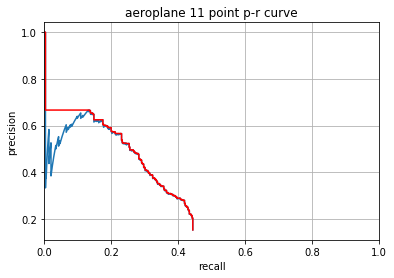

[class]: bicycle , [AP]: 0.23091046102251533
[Precisions] [1.         0.53608247 0.46706587 0.34124629 0.19562044 0.
 0.         0.         0.         0.         0.        ]


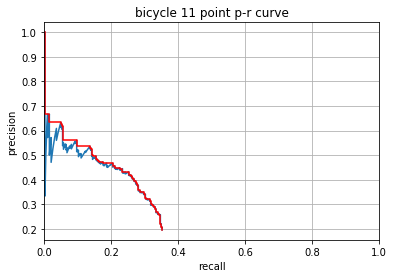

[class]: bird , [AP]: 0.18569180702588814
[Precisions] [1.         0.36824324 0.34710744 0.20633188 0.12092732 0.
 0.         0.         0.         0.         0.        ]


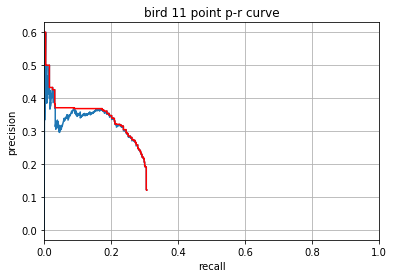

[class]: boat , [AP]: 0.1311118806065201
[Precisions] [1.         0.22053232 0.13396482 0.08773355 0.         0.
 0.         0.         0.         0.         0.        ]


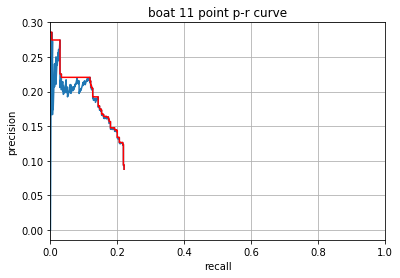

[class]: bottle , [AP]: 0.12514289833877462
[Precisions] [1.         0.23076923 0.14580265 0.         0.         0.
 0.         0.         0.         0.         0.        ]


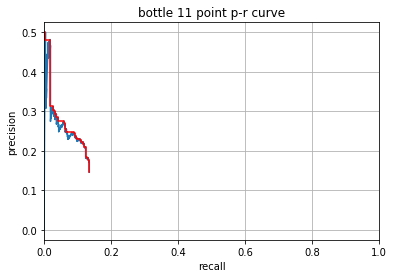

[class]: bus , [AP]: 0.4587160909224369
[Precisions] [1.         0.85714286 0.82352941 0.79508197 0.7037037  0.60447761
 0.26194145 0.         0.         0.         0.        ]


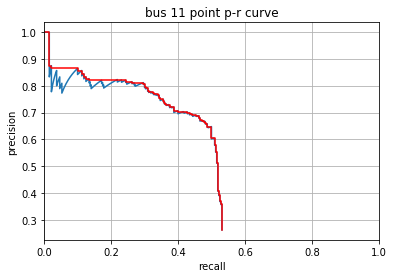

[class]: car , [AP]: 0.17263842659278342
[Precisions] [1.         0.42960289 0.29120198 0.17821782 0.         0.
 0.         0.         0.         0.         0.        ]


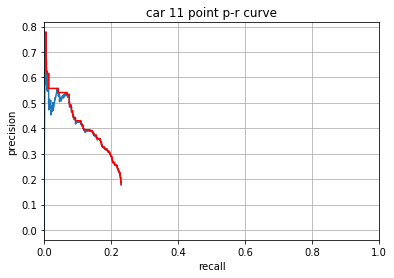

[class]: cat , [AP]: 0.2929198925400624
[Precisions] [1.         0.65957447 0.50806452 0.4372093  0.40277778 0.21449275
 0.         0.         0.         0.         0.        ]


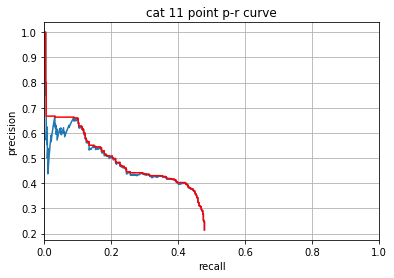

[class]: chair , [AP]: 0.13194744101057745
[Precisions] [1.         0.31160896 0.13981289 0.         0.         0.
 0.         0.         0.         0.         0.        ]


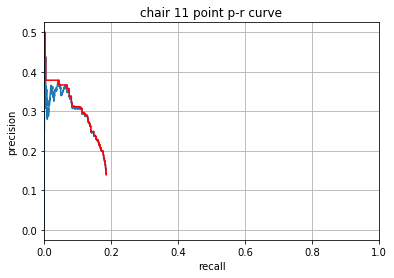

[class]: cow , [AP]: 0.18535292754990532
[Precisions] [1.         0.4469697  0.40935673 0.18255578 0.         0.
 0.         0.         0.         0.         0.        ]


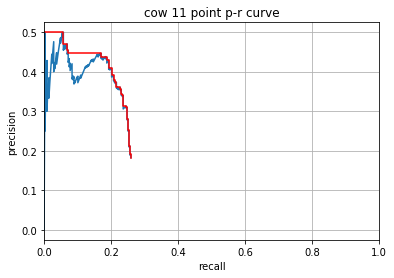

[class]: diningtable , [AP]: 0.11185961734405071
[Precisions] [1.         0.152      0.07845579 0.         0.         0.
 0.         0.         0.         0.         0.        ]


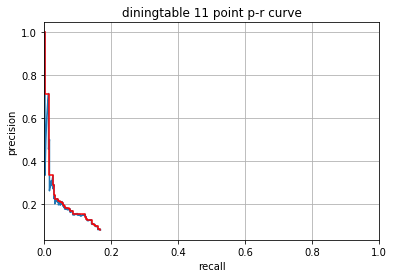

[class]: dog , [AP]: 0.1834201950562864
[Precisions] [1.         0.35087719 0.31187123 0.23654822 0.1183255  0.
 0.         0.         0.         0.         0.        ]


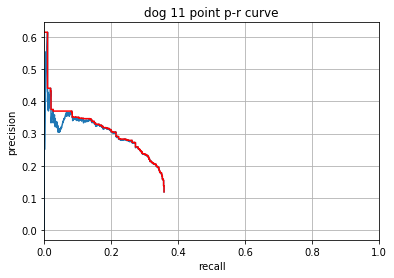

[class]: horse , [AP]: 0.3511559807186141
[Precisions] [1.         0.75       0.69642857 0.62827225 0.50324675 0.28476821
 0.         0.         0.         0.         0.        ]


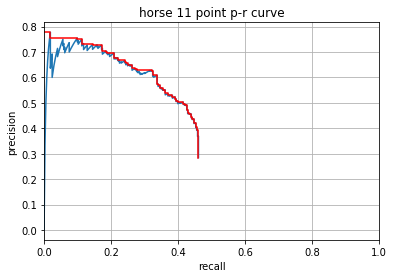

[class]: motorbike , [AP]: 0.30577103114028187
[Precisions] [1.         0.65957447 0.59398496 0.5255814  0.37562189 0.20871863
 0.         0.         0.         0.         0.        ]


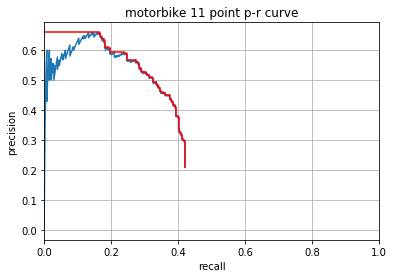

[class]: person , [AP]: 0.12835122751991068
[Precisions] [1.         0.27826087 0.13360263 0.         0.         0.
 0.         0.         0.         0.         0.        ]


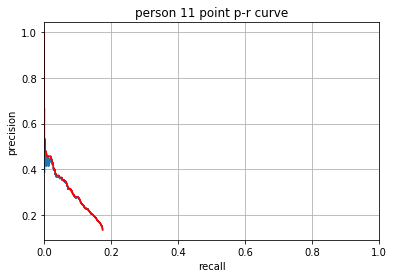

[class]: pottedplant , [AP]: 0.13186166464246624
[Precisions] [1.         0.30319149 0.14728682 0.         0.         0.
 0.         0.         0.         0.         0.        ]


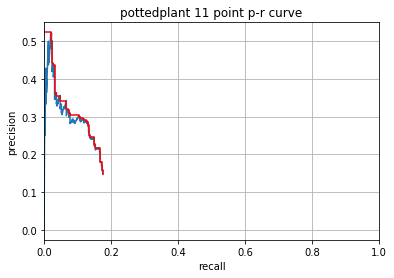

[class]: sheep , [AP]: 0.19276252062237084
[Precisions] [1.         0.52475248 0.40909091 0.18654434 0.         0.
 0.         0.         0.         0.         0.        ]


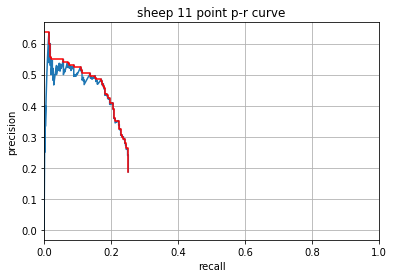

[class]: sofa , [AP]: 0.1879459384183291
[Precisions] [1.         0.37288136 0.33467742 0.22941176 0.13043478 0.
 0.         0.         0.         0.         0.        ]


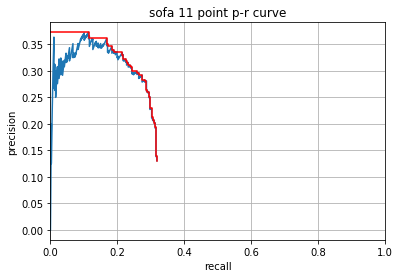

[class]: train , [AP]: 0.3180543921009108
[Precisions] [1.         0.825      0.62264151 0.52659574 0.37606838 0.14829268
 0.         0.         0.         0.         0.        ]


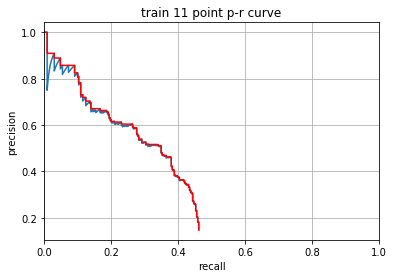

[class]: tvmonitor , [AP]: 0.19436684433887913
[Precisions] [1.         0.4368932  0.36363636 0.21182266 0.12568306 0.
 0.         0.         0.         0.         0.        ]


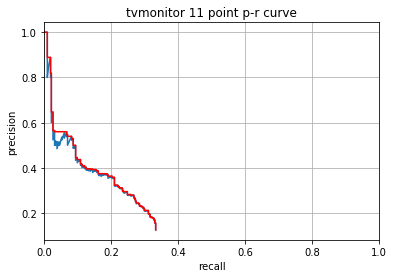

0.21518637077179764

In [50]:
from collections import Counter
# https://github.com/rafaelpadilla/Object-Detection-Metrics

def calc_AP(target):
    name = voc_classes[target]
    n_gt = Counter(target_all)

    _df = dfs[name].sort_values(by='confidience', ascending=False) # sort by conf

    _df['FP'] = [0 if tp==1 else 1 for tp in _df['TP']]
    _df['cum_TP'] = _df['TP'].cumsum()
    _df['cum_FP'] = _df['FP'].cumsum()
    _df['precision'] = [tp/(tp+fp) for tp,fp in zip(_df['cum_TP'],_df['cum_FP'])]
    _df['recall'] = _df['cum_TP']/n_gt[target]
    _df['precision_interpolated'] = [_df['precision'][i:].max() for i in range(len(_df['recall']))] 
    _df.reset_index(inplace=True)

    precisions = [_df['precision_interpolated'][_df['recall'].between(0.1*(i-1),0.1*i,inclusive=True)].min() for i in range(11)]
    precisions[0] = 1
    precisions = np.array([0 if p is np.nan else p for p in precisions])
    AP = precisions.mean()
    print('[class]:', name, ', [AP]:', AP)
    print('[Precisions]', precisions)

    plt.plot(_df['recall'], _df['precision'])
    plt.plot(_df['recall'], _df['precision_interpolated'], color='r')
    plt.grid()
    plt.xlim([0,1]), plt.title(name+' 11 point p-r curve')
    plt.xlabel('recall'), plt.ylabel('precision')
    plt.show()

    # display(_df)
    return AP
    
AP_list = np.array([calc_AP(t) for t in range(len(voc_classes)) ])
mAP = AP_list.mean()
mAP

In [51]:
list(zip(voc_classes, AP_list))

[('aeroplane', 0.2837461779243887),
 ('bicycle', 0.23091046102251533),
 ('bird', 0.18569180702588814),
 ('boat', 0.1311118806065201),
 ('bottle', 0.12514289833877462),
 ('bus', 0.4587160909224369),
 ('car', 0.17263842659278342),
 ('cat', 0.2929198925400624),
 ('chair', 0.13194744101057745),
 ('cow', 0.18535292754990532),
 ('diningtable', 0.11185961734405071),
 ('dog', 0.1834201950562864),
 ('horse', 0.3511559807186141),
 ('motorbike', 0.30577103114028187),
 ('person', 0.12835122751991068),
 ('pottedplant', 0.13186166464246624),
 ('sheep', 0.19276252062237084),
 ('sofa', 0.1879459384183291),
 ('train', 0.3180543921009108),
 ('tvmonitor', 0.19436684433887913)]

In [482]:
dd = torchvision.datasets.VOCDetection(root='./data', year='2007', 
                                       image_set='test', download=False, transform=None)
len(dd)

4952

In [229]:
import selectivesearch

In [259]:
# frame.shape
scale=1
frame = cv2.imread(".\\ttt.jpg")
frame = cv2.resize(frame, (int(frame.shape[1]*scale), int(frame.shape[0]*scale)), 
                              interpolation=cv2.INTER_CUBIC).astype(np.uint8)
%time img_lbl, regions = selectivesearch.selective_search(frame, scale=500, sigma=0.9, min_size=255)

print(len(regions))

for idx, b in enumerate(regions[:100]):
    x1, x2, y1, y2 = b['rect']
    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 1)   
    
cv2.imshow('frame',frame)
cv2.waitKey(0)
cv2.destroyAllWindows()      

Wall time: 2.6 s
167


In [254]:
img_lbl.shape
frame.shape
len(regions)
regions[0]
cv2.destroyAllWindows()      